In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from numba import njit

In [12]:
df = pd.read_csv("../sample_data/btc_5min_nan_processed_data.csv", parse_dates=["BAR_TIMESTAMP"])

In [13]:
df.head()

,EXCHANGE,SYMBOL,BAR_TIMESTAMP,MARK_PRICE_LAST,INDEX_PRICE_LAST,LAST_PRICE_LAST,OPEN_INTEREST_LAST,FUNDING_RATE_LAST,TICK_COUNT,BUY_LIQUIDATION_VOLUME,...,MIN_TRADE_SIZE,MAX_TRADE_SIZE,TRADE_SIZE_STDDEV,VOLUME_IMBALANCE,TRADE_COUNT_IMBALANCE,LIQ_DURATION,LIQ_LATENCY,TRADE_SPAN,TICK_SPAN,SECONDS_SINCE_FUNDING
0,binance-futures,BTCUSDT,2023-01-01 00:05:00,16521.500000,16527.421047,16521.5,105607.666,0.0001,534.0,0.0,...,0.001,8.458,0.360166,-86.071,-653.0,0.0,231.925,299.872,298.540,-28500.0
1,binance-futures,BTCUSDT,2023-01-01 00:10:00,16517.400000,16522.583810,16517.4,105604.357,0.0001,529.0,0.0,...,0.001,3.766,0.297205,19.624,-367.0,0.0,0.000,299.470,299.065,-28200.0
2,binance-futures,BTCUSDT,2023-01-01 00:15:00,16530.443023,16536.537968,16530.1,105641.237,0.0001,518.0,0.0,...,0.001,5.000,0.412914,68.448,452.0,0.0,142.478,299.206,298.994,-27900.0
3,binance-futures,BTCUSDT,2023-01-01 00:20:00,16531.800000,16536.153333,16531.8,105733.505,0.0001,512.0,0.0,...,0.001,5.057,0.348629,81.538,335.0,0.0,0.000,299.378,299.617,-27600.0
4,binance-futures,BTCUSDT,2023-01-01 00:25:00,16539.661913,16544.077064,16539.3,105796.920,0.0001,500.0,0.0,...,0.001,7.875,0.380222,68.634,535.0,0.0,0.000,299.600,299.589,-27300.0


In [14]:
df['BAR_TIMESTAMP'].aggregate(['min', 'max'])

min   2023-01-01 00:05:00
max   2025-09-30 23:55:00
Name: BAR_TIMESTAMP, dtype: datetime64[ns]

In [15]:
df.shape

(289151, 56)

In [87]:
df.isna().sum().sum()

np.int64(0)

In [88]:
df.columns.to_list()

['EXCHANGE',
 'SYMBOL',
 'BAR_TIMESTAMP',
 'MARK_PRICE_LAST',
 'INDEX_PRICE_LAST',
 'LAST_PRICE_LAST',
 'OPEN_INTEREST_LAST',
 'FUNDING_RATE_LAST',
 'TICK_COUNT',
 'BUY_LIQUIDATION_VOLUME',
 'SELL_LIQUIDATION_VOLUME',
 'TOTAL_LIQUIDATION_VOLUME',
 'BUY_LIQUIDATION_COUNT',
 'SELL_LIQUIDATION_COUNT',
 'TOTAL_LIQUIDATION_COUNT',
 'BUY_LIQUIDATION_NOTIONAL',
 'SELL_LIQUIDATION_NOTIONAL',
 'TOTAL_LIQUIDATION_NOTIONAL',
 'AVG_BUY_LIQUIDATION_SIZE',
 'AVG_SELL_LIQUIDATION_SIZE',
 'AVG_LIQUIDATION_SIZE',
 'MAX_SINGLE_LIQUIDATION_SIZE',
 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
 'MIN_LIQUIDATION_PRICE',
 'MAX_LIQUIDATION_PRICE',
 'AVG_LIQUIDATION_PRICE',
 'VWAP_LIQUIDATION_PRICE',
 'LIQUIDATION_VOLUME_IMBALANCE',
 'LIQUIDATION_COUNT_IMBALANCE',
 'OPEN_PRICE',
 'HIGH_PRICE',
 'LOW_PRICE',
 'CLOSE_PRICE',
 'VOLUME',
 'BUY_VOLUME',
 'SELL_VOLUME',
 'BUY_TRADES_COUNT',
 'SELL_TRADES_COUNT',
 'TOTAL_TRADES_COUNT',
 'NOTIONAL_VOLUME',
 'BUY_NOTIONAL',
 'SELL_NOTIONAL',
 'VWAP',
 'AVG_PRICE',
 'PRICE_STDDEV

# A. TARGET GENERATION 


 Triple barrier method + long only + short only = 3 targets 

In [95]:
df['CLOSE_PRICE'].head()

0    16521.5
1    16517.4
2    16530.1
3    16531.8
4    16539.4
Name: CLOSE_PRICE, dtype: float64

In [ ]:
import pandas as pd
import numpy as np
from numba import njit

# ==========================================
# 1. THE NUMBA ENGINE (Unchanged)
# ==========================================
@njit
def _triple_barrier_kernel(price_values, vol_values, width, expiry):
    n = len(price_values)
    out = np.zeros(n, dtype=np.int8) 

    for t in range(n - expiry):
        v_t = vol_values[t]
        if np.isnan(v_t) or v_t == 0: continue
            
        p_t = price_values[t]
        barrier_dist = p_t * v_t * width
        upper = p_t + barrier_dist
        lower = p_t - barrier_dist
        
        for i in range(1, expiry + 1):
            p_future = price_values[t + i]
            hit_up = p_future >= upper
            hit_down = p_future <= lower
            
            if hit_up and hit_down:
                out[t] = -1 
                break
            elif hit_up:
                out[t] = 1
                break
            elif hit_down:
                out[t] = -1
                break
    return out

# ==========================================
# 2. THE WRAPPER (Unchanged)
# ==========================================
def get_triple_barrier_label(price_series, vol_series, width, expiry, mode):
    p_arr = price_series.to_numpy().astype(np.float64)
    v_arr = vol_series.to_numpy().astype(np.float64)
    labels_arr = _triple_barrier_kernel(p_arr, v_arr, width, expiry)
    return pd.Series(labels_arr, index=price_series.index)

def buy_hold_label(price_series, expiry, mode, threshold=0.0):
    p_arr = price_series.to_numpy()
    future_price = np.full_like(p_arr, np.nan)
    future_price[:-expiry] = p_arr[expiry:]
    
    with np.errstate(divide='ignore', invalid='ignore'):
        ret = (future_price - p_arr) / p_arr
    ret = np.nan_to_num(ret, nan=0.0)
    
    if mode == 'long':
        labels = np.where(ret > threshold, 1, 0)
    elif mode == 'short':
        labels = np.where(ret < -threshold, 1, 0)
    else:
        labels = np.zeros(len(p_arr), dtype=int)
    return pd.Series(labels, index=price_series.index)

# ==========================================
# 3. FIXED GENERATE TARGETS
# ==========================================
def generate_targets(df, price_col='CLOSE_PRICE'):
    print(f"--- Extracting columns for processing ---")
    
    cols_to_keep = ['EXCHANGE', 'SYMBOL', 'BAR_TIMESTAMP', price_col]
    
    # Extract subset
    work_df = df[cols_to_keep].copy()
    
    # 2. Pre-process logic
    work_df['smooth_price'] = work_df[price_col].ewm(span=5).mean()
    
    # Calculate Volatility
    rets = work_df['smooth_price'].pct_change()
    vol_long = rets.ewm(span=100).std()

    print("--- Generating Targets (Optimized) ---")

    # 3. TRIPLE BARRIER
    print("Computing Triple Barrier...")
    target_both_tb = get_triple_barrier_label(
        work_df['smooth_price'], vol_long, width=1.0, expiry=24, mode='both'
    )

    # 4. STANDARD BUY & HOLD
    print("Computing Standard Long...")
    target_long_std = buy_hold_label(
        work_df['smooth_price'], expiry=24, mode='long', threshold=0.001
    )
    
    print("Computing Standard Short...")
    target_short_std = buy_hold_label(
        work_df['smooth_price'], expiry=24, mode='short', threshold=0.001
    )

    # 5. CONSTRUCT FINAL DF
    targets_df = pd.DataFrame(index=work_df.index)
    
    # Now this is safe because work_df has unique columns
    targets_df['EXCHANGE'] = work_df['EXCHANGE']
    targets_df['SYMBOL'] = work_df['SYMBOL']
    targets_df['BAR_TIMESTAMP'] = work_df['BAR_TIMESTAMP']
    targets_df['target_both_100_1_24_tb'] = target_both_tb
    targets_df['target_long_001_24_std'] = target_long_std
    targets_df['target_short_001_24_std'] = target_short_std
    
    return targets_df

In [97]:

# ==========================================
# USAGE & MERGE EXAMPLE
# ==========================================
    
# 1. Generate the targets (Pass your big dataframe here)
# This will return a small dataframe with only 3 columns
new_targets = generate_targets(df, price_col='CLOSE_PRICE')

--- Extracting columns for processing ---
--- Generating Targets (Optimized) ---
Computing Triple Barrier...
Computing Standard Long...
Computing Standard Short...


In [98]:
new_targets.head(10)

,EXCHANGE,SYMBOL,BAR_TIMESTAMP,target_both_100_1_24_tb,target_long_001_24_std,target_short_001_24_std
0,binance-futures,BTCUSDT,2023-01-01 00:05:00,0,1,0
1,binance-futures,BTCUSDT,2023-01-01 00:10:00,0,1,0
2,binance-futures,BTCUSDT,2023-01-01 00:15:00,1,1,0
3,binance-futures,BTCUSDT,2023-01-01 00:20:00,1,1,0
4,binance-futures,BTCUSDT,2023-01-01 00:25:00,-1,0,0
5,binance-futures,BTCUSDT,2023-01-01 00:30:00,-1,1,0
6,binance-futures,BTCUSDT,2023-01-01 00:35:00,-1,1,0
7,binance-futures,BTCUSDT,2023-01-01 00:40:00,1,1,0
8,binance-futures,BTCUSDT,2023-01-01 00:45:00,1,1,0
9,binance-futures,BTCUSDT,2023-01-01 00:50:00,1,1,0


In [99]:
gc.collect()

12557

In [100]:
new_targets.to_csv("../sample_data/targets.csv", index=False)

In [101]:
gc.collect()

0

In [26]:
new_targets = pd.read_csv("../sample_data/targets.csv")

In [28]:
df.columns

Index(['EXCHANGE', 'SYMBOL', 'BAR_TIMESTAMP', 'MARK_PRICE_LAST',
       'INDEX_PRICE_LAST', 'LAST_PRICE_LAST', 'OPEN_INTEREST_LAST',
       'FUNDING_RATE_LAST', 'FUNDING_TIMESTAMP_LAST', 'TICK_COUNT',
       'FIRST_TICK_TIMESTAMP', 'LAST_TICK_TIMESTAMP', 'BUY_LIQUIDATION_VOLUME',
       'SELL_LIQUIDATION_VOLUME', 'TOTAL_LIQUIDATION_VOLUME',
       'BUY_LIQUIDATION_COUNT', 'SELL_LIQUIDATION_COUNT',
       'TOTAL_LIQUIDATION_COUNT', 'BUY_LIQUIDATION_NOTIONAL',
       'SELL_LIQUIDATION_NOTIONAL', 'TOTAL_LIQUIDATION_NOTIONAL',
       'AVG_BUY_LIQUIDATION_SIZE', 'AVG_SELL_LIQUIDATION_SIZE',
       'AVG_LIQUIDATION_SIZE', 'MAX_SINGLE_LIQUIDATION_SIZE',
       'MAX_SINGLE_LIQUIDATION_NOTIONAL', 'MIN_LIQUIDATION_PRICE',
       'MAX_LIQUIDATION_PRICE', 'AVG_LIQUIDATION_PRICE',
       'VWAP_LIQUIDATION_PRICE', 'LIQUIDATION_VOLUME_IMBALANCE',
       'LIQUIDATION_COUNT_IMBALANCE', 'FIRST_LIQUIDATION_TIMESTAMP',
       'LAST_LIQUIDATION_TIMESTAMP', 'EXCHANGE.1', 'SYMBOL.1', 'OPEN_PRICE',
       'HI

# B. PREPROCESSING

In [70]:
df = pd.read_csv("../sample_data/btc_5min_nan_processed_data.csv", parse_dates=["BAR_TIMESTAMP"])

In [71]:
df = df[:50000]

In [72]:
df.head()

,EXCHANGE,SYMBOL,BAR_TIMESTAMP,MARK_PRICE_LAST,INDEX_PRICE_LAST,LAST_PRICE_LAST,OPEN_INTEREST_LAST,FUNDING_RATE_LAST,TICK_COUNT,BUY_LIQUIDATION_VOLUME,...,MIN_TRADE_SIZE,MAX_TRADE_SIZE,TRADE_SIZE_STDDEV,VOLUME_IMBALANCE,TRADE_COUNT_IMBALANCE,LIQ_DURATION,LIQ_LATENCY,TRADE_SPAN,TICK_SPAN,SECONDS_SINCE_FUNDING
0,binance-futures,BTCUSDT,2023-01-01 00:05:00,16521.500000,16527.421047,16521.5,105607.666,0.0001,534.0,0.0,...,0.001,8.458,0.360166,-86.071,-653.0,0.0,231.925,299.872,298.540,-28500.0
1,binance-futures,BTCUSDT,2023-01-01 00:10:00,16517.400000,16522.583810,16517.4,105604.357,0.0001,529.0,0.0,...,0.001,3.766,0.297205,19.624,-367.0,0.0,0.000,299.470,299.065,-28200.0
2,binance-futures,BTCUSDT,2023-01-01 00:15:00,16530.443023,16536.537968,16530.1,105641.237,0.0001,518.0,0.0,...,0.001,5.000,0.412914,68.448,452.0,0.0,142.478,299.206,298.994,-27900.0
3,binance-futures,BTCUSDT,2023-01-01 00:20:00,16531.800000,16536.153333,16531.8,105733.505,0.0001,512.0,0.0,...,0.001,5.057,0.348629,81.538,335.0,0.0,0.000,299.378,299.617,-27600.0
4,binance-futures,BTCUSDT,2023-01-01 00:25:00,16539.661913,16544.077064,16539.3,105796.920,0.0001,500.0,0.0,...,0.001,7.875,0.380222,68.634,535.0,0.0,0.000,299.600,299.589,-27300.0


In [73]:
gc.collect()

23664

In [74]:
df.shape

(50000, 56)

In [75]:
# ==============================================================================
# BUCKET A: PRICE & TREND (Drifting Memory)
# Transform: Log -> FracDiff (d=0.4) -> Rolling Z-Score (centre the bell curve)
# ==============================================================================
# Logic: These are non-stationary, high-memory time series. 
# We use FracDiff to preserve their trend history while making them stationary.
bucket_a_cols = [
    # Core OHLCV Prices
    'OPEN_PRICE', 'HIGH_PRICE', 'LOW_PRICE', 'CLOSE_PRICE',
    'VWAP', 'AVG_PRICE',

    # Exchange Reference Prices
    'MARK_PRICE_LAST', 'INDEX_PRICE_LAST', 'LAST_PRICE_LAST',

    # Market Trend State
    'OPEN_INTEREST_LAST' 
]

# ==============================================================================
# BUCKET B: VOLUME & ACTIVITY (Spiky / Heavy Tails)
# Transform: Log1p -> RobustScaler (IQR)
# ==============================================================================
# Logic: These are "burst" events bounded by 0 (cannot be negative).
# They follow power laws (whales). We Log to compress tails and RobustScale 
# to ignore the massive outliers in the scaling calculation.
bucket_b_cols = [
    # Standard Market Volume & Counts
    'VOLUME', 'BUY_VOLUME', 'SELL_VOLUME',
    'NOTIONAL_VOLUME', 'BUY_NOTIONAL', 'SELL_NOTIONAL',
    'TICK_COUNT', 
    'TOTAL_TRADES_COUNT', 'BUY_TRADES_COUNT', 'SELL_TRADES_COUNT',

    # Liquidation Activity (The Alpha)
    'BUY_LIQUIDATION_VOLUME', 'SELL_LIQUIDATION_VOLUME', 'TOTAL_LIQUIDATION_VOLUME',
    'BUY_LIQUIDATION_COUNT', 'SELL_LIQUIDATION_COUNT', 'TOTAL_LIQUIDATION_COUNT',
    'BUY_LIQUIDATION_NOTIONAL', 'SELL_LIQUIDATION_NOTIONAL', 'TOTAL_LIQUIDATION_NOTIONAL',

    # Size & Volatility Stats (Magnitudes)
    'AVG_TRADE_SIZE', 'MIN_TRADE_SIZE', 'MAX_TRADE_SIZE',
    'AVG_BUY_LIQUIDATION_SIZE', 'AVG_SELL_LIQUIDATION_SIZE', 'AVG_LIQUIDATION_SIZE',
    'MAX_SINGLE_LIQUIDATION_SIZE', 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
    'PRICE_STDDEV', 'TRADE_SIZE_STDDEV',

    # Time Velocity Features (New)
    'LIQ_DURATION', 'LIQ_LATENCY', 
    'TRADE_SPAN', 'TICK_SPAN', 
    'SECONDS_SINCE_FUNDING'
]

# ==============================================================================
# BUCKET C: RATIOS & OSCILLATORS (Bounded / Relative)
# Transform: Winsorize -> MinMax Scaler
# ==============================================================================
# Logic: These naturally oscillate around a mean (usually 0) or are ratios.
# We Winsorize to clip extreme deviations and MinMax to fit them into a fixed range.
bucket_c_cols = [
    # Market States
    'FUNDING_RATE_LAST',

    # Imbalances (Buying vs Selling pressure)
    'VOLUME_IMBALANCE', 'TRADE_COUNT_IMBALANCE',
    'LIQUIDATION_VOLUME_IMBALANCE', 'LIQUIDATION_COUNT_IMBALANCE',

    # Liquidation "Levels" (converted to Spreads)
    # NOTE: These are Prices, but we treat them as "Distance to Close" (Spreads).
    # If treated as raw prices in Bucket A, FracDiff would fail (due to ffill constant values).
    'MIN_LIQUIDATION_PRICE', 'MAX_LIQUIDATION_PRICE', 
    'AVG_LIQUIDATION_PRICE', 'VWAP_LIQUIDATION_PRICE'
]

# ==============================================================================
# UNUSED / METADATA
# ==============================================================================
# These will be set as Index or Dropped
ignore_cols = [
    'EXCHANGE', 'SYMBOL', 'BAR_TIMESTAMP'
]

In [76]:
assert( len(df.columns) == len(bucket_a_cols) + len(bucket_b_cols) + len(bucket_c_cols) + len(ignore_cols)  )

### COLUMN HYPOTHESIS TESTING

In [77]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from statsmodels.tsa.stattools import adfuller

def test_bucket_hypothesis(df, bucket_cols, bucket_name):
    print(f"\n--- TESTING {bucket_name} ---")
    results = []
    
    for col in bucket_cols:
        if col not in df.columns:
            continue
            
        series = df[col].dropna()
        if len(series) < 20: # Skip if empty
            continue
            
        # 1. Stationarity Test (ADF)
        # Null Hypothesis: Series is Non-Stationary.
        # p < 0.05 = Rejects Null (It IS Stationary).
        # p > 0.05 = Fails to Reject (It is Trending/Drifting).
        try:
            adf_result = adfuller(series.values, maxlag=1)
            p_value = adf_result[1]
        except:
            p_value = 1.0 # Default fail

        # 2. Heavy Tail Test (Kurtosis)
        # Normal Distribution = 3.0 (Fisher definition uses 0 as normal, so >0 is heavy)
        # We use Pearson (Normal = 3). Values > 3 imply "Spiky" outliers.
        kurt_val = kurtosis(series, fisher=False) 

        # 3. Sparsity (Zero %)
        zero_pct = (series == 0).mean()

        # --- EVALUATION LOGIC ---
        status = "PASS"
        reason = ""

        if bucket_name == "BUCKET_A":
            # Hypothesis: Should be Non-Stationary (High Memory)
            if p_value < 0.05: 
                status = "WARNING"
                reason = "Already Stationary (Maybe skip FracDiff?)"
        
        elif bucket_name == "BUCKET_B":
            # Hypothesis: Should be Spiky/Heavy Tailed
            if kurt_val < 3:
                status = "NOTE"
                reason = "Low Kurtosis (Not spiky, maybe standard scale?)"
        
        elif bucket_name == "BUCKET_C":
            # Hypothesis: Should be Stationary (Oscillator)
            # EXCEPTION: Liquidation Prices (MIN/MAX) are technically Prices (Drifting)
            # until we transform them to Spreads. We check this specifically.
            if "LIQUIDATION_PRICE" in col:
                # We expect raw prices to fail stationarity, proving they need transformation
                if p_value > 0.05:
                    status = "CONFIRMED"
                    reason = "Raw Price Drifts (Needs 'Spread' transform)"
                else:
                    status = "WEIRD"
                    reason = "Price is stationary??"
            elif p_value > 0.05:
                status = "WARNING"
                reason = "Non-Stationary (Ratio is drifting!)"

        # Append
        results.append({
            "Feature": col,
            "ADF_p_val": round(p_value, 4),
            "Kurtosis": round(kurt_val, 1),
            "Zeros%": round(zero_pct, 2),
            "Status": status,
            "Comment": reason
        })
    
    # Print Report
    report_df = pd.DataFrame(results)
    print(report_df.to_string())

# --- RUN THE TESTS ---

# 1. Test Bucket A (Expect High p-values)
test_bucket_hypothesis(df, bucket_a_cols, "BUCKET_A")

# 2. Test Bucket B (Expect High Kurtosis)
test_bucket_hypothesis(df, bucket_b_cols, "BUCKET_B")

# 3. Test Bucket C (Expect Low p-values, except for Raw Liq Prices)
test_bucket_hypothesis(df, bucket_c_cols, "BUCKET_C")


--- TESTING BUCKET_A ---
              Feature  ADF_p_val  Kurtosis  Zeros%   Status                                    Comment
0          OPEN_PRICE     0.2573       2.9     0.0     PASS                                           
1          HIGH_PRICE     0.2455       2.9     0.0     PASS                                           
2           LOW_PRICE     0.2448       2.9     0.0     PASS                                           
3         CLOSE_PRICE     0.2564       2.9     0.0     PASS                                           
4                VWAP     0.2482       2.9     0.0     PASS                                           
5           AVG_PRICE     0.2481       2.9     0.0     PASS                                           
6     MARK_PRICE_LAST     0.2566       2.9     0.0     PASS                                           
7    INDEX_PRICE_LAST     0.2576       2.9     0.0     PASS                                           
8     LAST_PRICE_LAST     0.2564       2.9     

C:\Users\Dhruv\AppData\Local\Temp\ipykernel_14948\2734558467.py:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(series, fisher=False)


                            Feature  ADF_p_val  Kurtosis  Zeros% Status                                          Comment
0                            VOLUME        0.0      61.7    0.00   PASS                                                 
1                        BUY_VOLUME        0.0      68.6    0.00   PASS                                                 
2                       SELL_VOLUME        0.0      67.3    0.00   PASS                                                 
3                   NOTIONAL_VOLUME        0.0      61.0    0.00   PASS                                                 
4                      BUY_NOTIONAL        0.0      66.4    0.00   PASS                                                 
5                     SELL_NOTIONAL        0.0      67.4    0.00   PASS                                                 
6                        TICK_COUNT        0.0       3.5    0.00   PASS                                                 
7                TOTAL_TRADES_CO

In [78]:
# result based editing of buckets
bucket_a_cols = [
    'OPEN_PRICE', 'HIGH_PRICE', 'LOW_PRICE', 'CLOSE_PRICE',
    'VWAP', 'AVG_PRICE',
    'MARK_PRICE_LAST', 'INDEX_PRICE_LAST', 'LAST_PRICE_LAST'
]
# REMOVED: OPEN_INTEREST_LAST (Moved to B)
bucket_b_cols = [
    # Moved Here:
    'OPEN_INTEREST_LAST', 

    # Existing:
    'VOLUME', 'BUY_VOLUME', 'SELL_VOLUME',
    'NOTIONAL_VOLUME', 'BUY_NOTIONAL', 'SELL_NOTIONAL',
    'TICK_COUNT', 'TOTAL_TRADES_COUNT', 'BUY_TRADES_COUNT', 'SELL_TRADES_COUNT',

    # Liquidation Alpha (Massive Kurtosis confirmed)
    'BUY_LIQUIDATION_VOLUME', 'SELL_LIQUIDATION_VOLUME', 'TOTAL_LIQUIDATION_VOLUME',
    'BUY_LIQUIDATION_COUNT', 'SELL_LIQUIDATION_COUNT', 'TOTAL_LIQUIDATION_COUNT',
    'BUY_LIQUIDATION_NOTIONAL', 'SELL_LIQUIDATION_NOTIONAL', 'TOTAL_LIQUIDATION_NOTIONAL',

    # Sizes
    'AVG_TRADE_SIZE', 'MIN_TRADE_SIZE', 'MAX_TRADE_SIZE',
    'AVG_BUY_LIQUIDATION_SIZE', 'AVG_SELL_LIQUIDATION_SIZE', 'AVG_LIQUIDATION_SIZE',
    'MAX_SINGLE_LIQUIDATION_SIZE', 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
    'PRICE_STDDEV', 'TRADE_SIZE_STDDEV',

    # Velocity
    'LIQ_DURATION', 'LIQ_LATENCY', 
    'TRADE_SPAN', 'TICK_SPAN'
]
# REMOVED: SECONDS_SINCE_FUNDING (Moved to C)
bucket_c_cols = [
    # Moved Here:
    'SECONDS_SINCE_FUNDING', # It's a periodic cycle (Oscillator)

    # Existing:
    'FUNDING_RATE_LAST',
    'VOLUME_IMBALANCE', 'TRADE_COUNT_IMBALANCE',
    'LIQUIDATION_VOLUME_IMBALANCE', 'LIQUIDATION_COUNT_IMBALANCE',

    # Liquidation Levels (MUST be transformed to Spreads)
    'MIN_LIQUIDATION_PRICE', 'MAX_LIQUIDATION_PRICE', 
    'AVG_LIQUIDATION_PRICE', 'VWAP_LIQUIDATION_PRICE'
]

In [79]:
gc.collect()

0

In [80]:
# ==============================================================================
# STEP 1: TRANSFORM LIQUIDATION PRICES -> STATIONARY SPREADS
# ==============================================================================

# 1. Define the targets (Raw Level -> Distance)
# We map the raw column name to a new feature name
liq_transform_map = {
    'MIN_LIQUIDATION_PRICE': 'DIST_MIN_LIQ',
    'MAX_LIQUIDATION_PRICE': 'DIST_MAX_LIQ',
    'AVG_LIQUIDATION_PRICE': 'DIST_AVG_LIQ',
    'VWAP_LIQUIDATION_PRICE': 'DIST_VWAP_LIQ'
}

print("--- TRANSFORMING LIQUIDATION PRICES ---")

for raw_col, new_col in liq_transform_map.items():
    if raw_col in df.columns:
        # A. Calculate Log-Spread: Log(Liq) - Log(Close)
        # This creates a stationary "percentage distance" metric
        df[new_col] = np.log(df[raw_col]) - np.log(df['CLOSE_PRICE'])
        
        # B. Handle NaNs (just in case any slipped through, though we cleaned them)
        df[new_col] = df[new_col].fillna(0)
        
        # C. Drop the original Raw Price column (it's dangerous for ML)
        df.drop(columns=[raw_col], inplace=True)
        
        print(f"Created {new_col} | Dropped {raw_col}")



--- TRANSFORMING LIQUIDATION PRICES ---
Created DIST_MIN_LIQ | Dropped MIN_LIQUIDATION_PRICE
Created DIST_MAX_LIQ | Dropped MAX_LIQUIDATION_PRICE
Created DIST_AVG_LIQ | Dropped AVG_LIQUIDATION_PRICE
Created DIST_VWAP_LIQ | Dropped VWAP_LIQUIDATION_PRICE


In [81]:
# 2. Update the Python List 'bucket_c_cols'
# We remove the old names and add the new 'DIST_' names so your list stays valid.
bucket_c_cols = [col for col in bucket_c_cols if col not in liq_transform_map.keys()]
bucket_c_cols.extend(liq_transform_map.values())

print("\nUpdated Bucket C List:")
print(bucket_c_cols)


Updated Bucket C List:
['SECONDS_SINCE_FUNDING', 'FUNDING_RATE_LAST', 'VOLUME_IMBALANCE', 'TRADE_COUNT_IMBALANCE', 'LIQUIDATION_VOLUME_IMBALANCE', 'LIQUIDATION_COUNT_IMBALANCE', 'DIST_MIN_LIQ', 'DIST_MAX_LIQ', 'DIST_AVG_LIQ', 'DIST_VWAP_LIQ']


In [82]:
df.shape

(50000, 56)

In [83]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
# ==============================================================================
# HELPER: FAST FRACTIONAL DIFFERENTIATION (Fixed Window)
# ==============================================================================
# Preserves trend memory without drift.
def get_weights_ffd(d, thres):
    w, k = [1.], 1
    while True:
        w_k = -w[-1] / k * (d - k + 1)
        if abs(w_k) < thres:
            break
        w.append(w_k)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)

def frac_diff_ffd(series, d=0.4, thres=1e-5):
    # 1. Compute weights (w is returned as [w_K, ..., w_0])
    w = get_weights_ffd(d, thres).flatten()
    width = len(w)
    
    # 2. Filter valid data (remove existing NaNs to process)
    # We maintain indices to map back to the original series
    series_clean = series.dropna()
    if len(series_clean) < width:
        return pd.Series(index=series.index, dtype=float)
        
    # 3. Create a windowed view of the data (N, width)
    # This creates a view, not a copy, so it is memory efficient
    windows = sliding_window_view(series_clean.values, window_shape=width)
    
    # 4. Apply dot product vectorized
    # windows shape: (n_obs - width + 1, width)
    # w shape: (width,)
    result_values = np.dot(windows, w)
    
    # 5. Realign with index
    # The result corresponds to the timestamps starting from series_clean.index[width-1]
    result_index = series_clean.index[width-1:]
    
    return pd.Series(result_values, index=result_index).reindex(series.index)

In [84]:
# ==============================================================================
# BUCKET A PROCESS (Log -> FracDiff -> Rolling Z-Score)
# ==============================================================================
def bucket_a_process(df, cols, meta_cols=['SYMBOL', 'EXCHANGE', 'BAR_TIMESTAMP'], 
                     window=2000, d=0.4):
    
    print("\n--- PROCESSING BUCKET A (Trend) ---")
    
    # 1. Create Isolated DataFrame
    df_a = df[meta_cols + cols].copy()
    
    # 2. Apply Transformations
    for col in cols:
        if col not in df_a.columns:
            continue
            
        print(f"Processing {col}...")
        
        # A. Log Transform
        df_a[col] = np.log(df_a[col] + 1e-9)
        
        # B. FracDiff
        df_a[col] = frac_diff_ffd(df_a[col], d=d)
        
        # C. Rolling Z-Score
        rolling_mean = df_a[col].rolling(window=window).mean()
        rolling_std = df_a[col].rolling(window=window).std()
        df_a[col] = (df_a[col] - rolling_mean) / (rolling_std + 1e-9)

    # 3. Rename Columns (Add suffix '_A')
    # We create a dictionary mapping old_name -> old_name_A
    rename_map = {col: f"{col}_A" for col in cols}
    df_a.rename(columns=rename_map, inplace=True)
    
    print(f"Bucket A Complete. Shape: {df_a.shape}")
    return df_a

# --- EXECUTE ---
# Run the function
df_bucket_a = bucket_a_process(df, bucket_a_cols)

# Check the output
print(df_bucket_a.tail())


--- PROCESSING BUCKET A (Trend) ---
Processing OPEN_PRICE...
Processing HIGH_PRICE...
Processing LOW_PRICE...
Processing CLOSE_PRICE...
Processing VWAP...
Processing AVG_PRICE...
Processing MARK_PRICE_LAST...
Processing INDEX_PRICE_LAST...
Processing LAST_PRICE_LAST...
Bucket A Complete. Shape: (50000, 12)
        SYMBOL         EXCHANGE       BAR_TIMESTAMP  OPEN_PRICE_A  \
49995  BTCUSDT  binance-futures 2023-06-23 14:20:00      1.116821   
49996  BTCUSDT  binance-futures 2023-06-23 14:25:00      0.380731   
49997  BTCUSDT  binance-futures 2023-06-23 14:30:00      0.826106   
49998  BTCUSDT  binance-futures 2023-06-23 14:35:00      0.477387   
49999  BTCUSDT  binance-futures 2023-06-23 14:40:00      0.805165   

       HIGH_PRICE_A  LOW_PRICE_A  CLOSE_PRICE_A    VWAP_A  AVG_PRICE_A  \
49995      0.622424     0.670087       0.380805  0.536308     0.537626   
49996      0.602425     0.775975       0.826135  0.683616     0.675956   
49997      0.522035     0.621532       0.477423  0.542

In [85]:
df_bucket_a.tail()

,SYMBOL,EXCHANGE,BAR_TIMESTAMP,OPEN_PRICE_A,HIGH_PRICE_A,LOW_PRICE_A,CLOSE_PRICE_A,VWAP_A,AVG_PRICE_A,MARK_PRICE_LAST_A,INDEX_PRICE_LAST_A,LAST_PRICE_LAST_A
49995,BTCUSDT,binance-futures,2023-06-23 14:20:00,1.116821,0.622424,0.670087,0.380805,0.536308,0.537626,0.378617,0.402987,0.383166
49996,BTCUSDT,binance-futures,2023-06-23 14:25:00,0.380731,0.602425,0.775975,0.826135,0.683616,0.675956,0.821526,0.807935,0.827851
49997,BTCUSDT,binance-futures,2023-06-23 14:30:00,0.826106,0.522035,0.621532,0.477423,0.542029,0.550507,0.468857,0.483097,0.478697
49998,BTCUSDT,binance-futures,2023-06-23 14:35:00,0.477387,0.641531,0.811475,0.804385,0.781386,0.778588,0.822076,0.825245,0.806313
49999,BTCUSDT,binance-futures,2023-06-23 14:40:00,0.805165,0.582947,0.804622,0.652852,0.700305,0.682951,0.637427,0.645584,0.653491


In [86]:
# ==============================================================================
# BUCKET B PROCESS (Log1p -> Rolling Robust Scaler -> Rename)
# ==============================================================================
def bucket_b_process(df, cols, meta_cols=['SYMBOL', 'EXCHANGE', 'BAR_TIMESTAMP'], 
                     window=2000):
    
    print("\n--- PROCESSING BUCKET B (Activity) ---")
    
    # 1. Create Isolated DataFrame
    # Filter to only columns that actually exist in the dataframe
    valid_cols = [c for c in cols if c in df.columns]
    df_b = df[meta_cols + valid_cols].copy()
    
    for col in valid_cols:
        print(f"Processing {col}...")
        
        # A. Log1p Transform
        # Compresses power-law tails (e.g., 1000 BTC volume vs 1 BTC)
        # log1p is safe for 0 values (log(0+1) = 0)
        df_b[col] = np.log1p(df_b[col])
        
        # B. Rolling Robust Scaler (Quantile-Based)
        # We use Median/IQR instead of Mean/Std because Mean is ruined by outliers.
        
        # Calculate Rolling Stats (Past 2000 bars)
        rolling_median = df_b[col].rolling(window=window).median()
        rolling_q75 = df_b[col].rolling(window=window).quantile(0.75)
        rolling_q25 = df_b[col].rolling(window=window).quantile(0.25)
        rolling_iqr = rolling_q75 - rolling_q25
        
        # Apply Scaling
        # We add a tiny epsilon to IQR to avoid division by zero during flat periods
        df_b[col] = (df_b[col] - rolling_median) / (rolling_iqr + 1e-9)

    # 3. Rename Columns (Add suffix '_B')
    rename_map = {col: f"{col}_B" for col in valid_cols}
    df_b.rename(columns=rename_map, inplace=True)
    
    print(f"Bucket B Complete. Shape: {df_b.shape}")
    return df_b

# --- EXECUTE ---
# Note: Ensure bucket_b_cols is updated (contains 'OPEN_INTEREST_LAST' etc.)
df_bucket_b = bucket_b_process(df, bucket_b_cols)

# Verify Output
print("\nNew Feature Sample (Robust Scaled):")
print(df_bucket_b.tail())


--- PROCESSING BUCKET B (Activity) ---
Processing OPEN_INTEREST_LAST...
Processing VOLUME...
Processing BUY_VOLUME...
Processing SELL_VOLUME...
Processing NOTIONAL_VOLUME...
Processing BUY_NOTIONAL...
Processing SELL_NOTIONAL...
Processing TICK_COUNT...
Processing TOTAL_TRADES_COUNT...
Processing BUY_TRADES_COUNT...
Processing SELL_TRADES_COUNT...
Processing BUY_LIQUIDATION_VOLUME...
Processing SELL_LIQUIDATION_VOLUME...
Processing TOTAL_LIQUIDATION_VOLUME...
Processing BUY_LIQUIDATION_COUNT...
Processing SELL_LIQUIDATION_COUNT...
Processing TOTAL_LIQUIDATION_COUNT...
Processing BUY_LIQUIDATION_NOTIONAL...
Processing SELL_LIQUIDATION_NOTIONAL...
Processing TOTAL_LIQUIDATION_NOTIONAL...
Processing AVG_TRADE_SIZE...
Processing MIN_TRADE_SIZE...
Processing MAX_TRADE_SIZE...
Processing AVG_BUY_LIQUIDATION_SIZE...
Processing AVG_SELL_LIQUIDATION_SIZE...
Processing AVG_LIQUIDATION_SIZE...
Processing MAX_SINGLE_LIQUIDATION_SIZE...
Processing MAX_SINGLE_LIQUIDATION_NOTIONAL...
Processing PRIC

In [87]:
df_bucket_b.tail()

,SYMBOL,EXCHANGE,BAR_TIMESTAMP,OPEN_INTEREST_LAST_B,VOLUME_B,BUY_VOLUME_B,SELL_VOLUME_B,NOTIONAL_VOLUME_B,BUY_NOTIONAL_B,SELL_NOTIONAL_B,...,AVG_SELL_LIQUIDATION_SIZE_B,AVG_LIQUIDATION_SIZE_B,MAX_SINGLE_LIQUIDATION_SIZE_B,MAX_SINGLE_LIQUIDATION_NOTIONAL_B,PRICE_STDDEV_B,TRADE_SIZE_STDDEV_B,LIQ_DURATION_B,LIQ_LATENCY_B,TRADE_SPAN_B,TICK_SPAN_B
49995,BTCUSDT,binance-futures,2023-06-23 14:20:00,0.789843,0.349798,0.177403,0.462575,0.400740,0.229825,0.513457,...,0.0,0.000000,0.000000,0.000000,0.790468,-0.366101,0.0,0.000000,0.373781,-0.012498
49996,BTCUSDT,binance-futures,2023-06-23 14:25:00,0.798970,0.490590,0.633380,0.275587,0.538772,0.671610,0.330947,...,0.0,0.000000,0.000000,0.000000,0.389949,2.014356,0.0,0.000000,0.238691,-0.576013
49997,BTCUSDT,binance-futures,2023-06-23 14:30:00,0.800247,0.409428,0.100424,0.596469,0.459220,0.155399,0.642754,...,0.0,0.000000,0.000000,0.000000,0.444347,1.120706,0.0,0.000000,-1.451066,0.194777
49998,BTCUSDT,binance-futures,2023-06-23 14:35:00,0.813989,0.231320,0.295266,0.138055,0.285893,0.344864,0.196211,...,0.0,0.764929,0.346117,0.870383,0.152297,0.066858,0.0,0.993179,-0.252248,-0.572336
49999,BTCUSDT,binance-futures,2023-06-23 14:40:00,0.823074,-0.045535,0.044640,-0.159004,0.014655,0.102443,-0.092256,...,0.0,0.000000,0.000000,0.000000,-0.042280,-0.249407,0.0,0.000000,-0.742528,-2.044843


In [88]:
import pandas as pd
import numpy as np

# ==============================================================================
# BUCKET C PROCESS (Rolling Winsorize -> Rolling MinMax -> Rename)
# ==============================================================================
def bucket_c_process(df, cols, meta_cols=['SYMBOL', 'EXCHANGE', 'BAR_TIMESTAMP'], 
                     window=2000):
    
    print("\n--- PROCESSING BUCKET C (Oscillators) ---")
    
    valid_cols = [c for c in cols if c in df.columns]
    df_c = df[meta_cols + valid_cols].copy()
    
    for col in valid_cols:
        print(f"Processing {col}...")
        
        # 1. Rolling Winsorization (Clipping)
        # We calculate the rolling 1st and 99th percentiles
        roll_p01 = df_c[col].rolling(window=window).quantile(0.01)
        roll_p99 = df_c[col].rolling(window=window).quantile(0.99)
        
        # Clip the data to these dynamic bounds
        # We use .clip() with the rolling series (aligned by index)
        # Note: 'clip' with series arguments requires matching indices
        df_c[col] = df_c[col].clip(lower=roll_p01, upper=roll_p99, axis=0)
        
        # 2. Rolling MinMax Scaler
        # Now we scale based on the clipped range
        roll_min = df_c[col].rolling(window=window).min()
        roll_max = df_c[col].rolling(window=window).max()
        roll_range = roll_max - roll_min
        
        # Apply Scaling (Result is 0.0 to 1.0)
        df_c[col] = (df_c[col] - roll_min) / (roll_range + 1e-9)

    # 3. Rename Columns (Add suffix '_C')
    rename_map = {col: f"{col}_C" for col in valid_cols}
    df_c.rename(columns=rename_map, inplace=True)
    
    print(f"Bucket C Complete. Shape: {df_c.shape}")
    return df_c

# --- EXECUTE ---
df_bucket_c = bucket_c_process(df, bucket_c_cols)



--- PROCESSING BUCKET C (Oscillators) ---
Processing SECONDS_SINCE_FUNDING...
Processing FUNDING_RATE_LAST...
Processing VOLUME_IMBALANCE...
Processing TRADE_COUNT_IMBALANCE...
Processing LIQUIDATION_VOLUME_IMBALANCE...
Processing LIQUIDATION_COUNT_IMBALANCE...
Processing DIST_MIN_LIQ...
Processing DIST_MAX_LIQ...
Processing DIST_AVG_LIQ...
Processing DIST_VWAP_LIQ...
Bucket C Complete. Shape: (50000, 13)


In [89]:

# Verify (Check min/max to ensure they are strictly within 0-1)
print("\nStats Check (Should be 0.0 to 1.0):")
print(df_bucket_c.describe().loc[['min', 'max']])


Stats Check (Should be 0.0 to 1.0):
           BAR_TIMESTAMP  SECONDS_SINCE_FUNDING_C  FUNDING_RATE_LAST_C  \
min  2023-01-01 00:05:00                      0.0             0.000000   
max  2023-06-23 14:40:00                      1.0             0.999998   

     VOLUME_IMBALANCE_C  TRADE_COUNT_IMBALANCE_C  \
min                 0.0                      0.0   
max                 1.0                      1.0   

     LIQUIDATION_VOLUME_IMBALANCE_C  LIQUIDATION_COUNT_IMBALANCE_C  \
min                             0.0                            0.0   
max                             1.0                            1.0   

     DIST_MIN_LIQ_C  DIST_MAX_LIQ_C  DIST_AVG_LIQ_C  DIST_VWAP_LIQ_C  
min             0.0             0.0             0.0              0.0  
max             1.0             1.0             1.0              1.0  


### FINAL MERGE OF ALL FEATURES

In [90]:
missing_a = [a for a in bucket_a_cols if (a+"_A") not in df_bucket_a.columns.tolist()]
missing_b = [b for b in bucket_b_cols if (b+"_B") not in df_bucket_b.columns.tolist()]
missing_c = [c for c in bucket_c_cols if (c+"_C") not in df_bucket_c.columns.tolist()]

In [91]:
missing_a, missing_b, missing_c

([], [], [])

In [92]:
missing_cols = [v for v in bucket_a_cols + bucket_b_cols + bucket_c_cols if v not in df.columns.tolist()]

In [93]:
missing_cols

[]

In [94]:

# ==============================================================================
# PHASE 3: FINAL MERGE & CLEANUP
# ==============================================================================
print("--- STARTING FINAL MERGE ---")

# 1. Merge Bucket A + Bucket B
# Inner join ensures we only keep rows that exist in both (safety check)
df_final = pd.merge(
    df_bucket_a, 
    df_bucket_b, 
    on=['SYMBOL', 'EXCHANGE', 'BAR_TIMESTAMP'], 
    how='inner'
)

# 2. Merge Result + Bucket C
df_final = pd.merge(
    df_final, 
    df_bucket_c, 
    on=['SYMBOL', 'EXCHANGE', 'BAR_TIMESTAMP'], 
    how='inner'
)

# 3. Final Cleanup: Drop "Warmup" NaNs
# Our rolling windows (2000 bars) created NaNs at the start of the dataset.
# We must drop these rows so the model doesn't see garbage.
rows_before = len(df_final)
df_final.dropna(inplace=True)
rows_dropped = rows_before - len(df_final)



--- STARTING FINAL MERGE ---


In [95]:

# ==============================================================================
# FINAL VERIFICATION
# ==============================================================================
print(f"\n--- MERGE COMPLETE ---")
print(f"Original Rows:  {rows_before}")
print(f"Dropped (Warmup): {rows_dropped} (Matches your window size?)")
print(f"Final Shape:    {df_final.shape}")
print(f"Total Features: {len(df_final.columns) - 2}") # Excluding Symbol/Exchange

# Check for any lingering NaNs
nan_count = df_final.isna().sum().sum()
if nan_count == 0:
    print("Status: SUCCESS (0 NaNs found. Dataset is fully dense.)")
else:
    print(f"Status: WARNING ({nan_count} NaNs remain!)")

# Preview
print("\nFeature Matrix Preview:")
print(df_final.iloc[:5, :5]) # Show first 5 rows/cols


--- MERGE COMPLETE ---
Original Rows:  50000
Dropped (Warmup): 3456 (Matches your window size?)
Final Shape:    (46544, 56)
Total Features: 54
Status: SUCCESS (0 NaNs found. Dataset is fully dense.)

Feature Matrix Preview:
       SYMBOL         EXCHANGE       BAR_TIMESTAMP  OPEN_PRICE_A  HIGH_PRICE_A
3456  BTCUSDT  binance-futures 2023-01-13 00:05:00      2.379496      1.914722
3457  BTCUSDT  binance-futures 2023-01-13 00:10:00      1.414735      1.362915
3458  BTCUSDT  binance-futures 2023-01-13 00:15:00      1.764843      1.899881
3459  BTCUSDT  binance-futures 2023-01-13 00:20:00      2.188605      2.298841
3460  BTCUSDT  binance-futures 2023-01-13 00:25:00      2.109391      1.772836


In [96]:
df_final.shape

(46544, 56)

In [97]:
df_final.to_csv("btc_5min_proc_features.csv", index=False)

In [98]:
# --- RUN THE TESTS ---

# 1. Test Bucket A (Expect High p-values)
test_bucket_hypothesis(df_final,[a for a in  df_bucket_a.columns.to_list() if ("BAR_TIMESTAMP" not in a) and ("EXCHANGE" not in a) and ("SYMBOL" not in a)], "BUCKET_A")

# 2. Test Bucket B (Expect High Kurtosis)
test_bucket_hypothesis(df_final, [a for a in  df_bucket_b.columns.to_list() if ("BAR_TIMESTAMP" not in a) and ("EXCHANGE" not in a) and ("SYMBOL" not in a)], "BUCKET_B")

# 3. Test Bucket C (Expect Low p-values, except for Raw Liq Prices)
test_bucket_hypothesis(df_final, [a for a in  df_bucket_c.columns.to_list() if ("BAR_TIMESTAMP" not in a) and ("EXCHANGE" not in a) and ("SYMBOL" not in a)], "BUCKET_C")



--- TESTING BUCKET_A ---
              Feature  ADF_p_val  Kurtosis  Zeros%   Status                                    Comment
0        OPEN_PRICE_A        0.0       9.9     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
1        HIGH_PRICE_A        0.0       9.8     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
2         LOW_PRICE_A        0.0      12.6     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
3       CLOSE_PRICE_A        0.0       9.9     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
4              VWAP_A        0.0       9.2     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
5         AVG_PRICE_A        0.0       9.2     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
6   MARK_PRICE_LAST_A        0.0       9.7     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
7  INDEX_PRICE_LAST_A        0.0       9.7     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
8   LAST_PRICE_LAST_A        0.0      10.3     

In [99]:
# ==========================================
# PHASE 3.5: POST-TRANSFORM CLEANUP (FIXED)
# ==========================================

# 1. Identify Numeric Columns First
# We only calculate std() on actual numbers to avoid string errors
numeric_cols = df_final.select_dtypes(include=[np.number]).columns

# 2. Identify Constant Columns (Zero Variance) within numeric cols
# We assume if std() is 0 (or NaN/Null for safety), it provides no signal.
constant_cols = [col for col in numeric_cols if df_final[col].std() == 0]

print(f"--- DROPPING CONSTANT COLUMNS ({len(constant_cols)}) ---")
print(constant_cols)

# 3. Drop them from the main DataFrame
if constant_cols:
    df_final.drop(columns=constant_cols, inplace=True)

# 4. Final Shape Check
print(f"Final Clean Matrix Shape: {df_final.shape}")

--- DROPPING CONSTANT COLUMNS (1) ---
['MIN_TRADE_SIZE_B']
Final Clean Matrix Shape: (46544, 55)


In [100]:
df_final.to_csv("../sample_data/btc_5min_proc_features_clean.csv", index=False)

In [101]:
df_final.columns.tolist()

['SYMBOL',
 'EXCHANGE',
 'BAR_TIMESTAMP',
 'OPEN_PRICE_A',
 'HIGH_PRICE_A',
 'LOW_PRICE_A',
 'CLOSE_PRICE_A',
 'VWAP_A',
 'AVG_PRICE_A',
 'MARK_PRICE_LAST_A',
 'INDEX_PRICE_LAST_A',
 'LAST_PRICE_LAST_A',
 'OPEN_INTEREST_LAST_B',
 'VOLUME_B',
 'BUY_VOLUME_B',
 'SELL_VOLUME_B',
 'NOTIONAL_VOLUME_B',
 'BUY_NOTIONAL_B',
 'SELL_NOTIONAL_B',
 'TICK_COUNT_B',
 'TOTAL_TRADES_COUNT_B',
 'BUY_TRADES_COUNT_B',
 'SELL_TRADES_COUNT_B',
 'BUY_LIQUIDATION_VOLUME_B',
 'SELL_LIQUIDATION_VOLUME_B',
 'TOTAL_LIQUIDATION_VOLUME_B',
 'BUY_LIQUIDATION_COUNT_B',
 'SELL_LIQUIDATION_COUNT_B',
 'TOTAL_LIQUIDATION_COUNT_B',
 'BUY_LIQUIDATION_NOTIONAL_B',
 'SELL_LIQUIDATION_NOTIONAL_B',
 'TOTAL_LIQUIDATION_NOTIONAL_B',
 'AVG_TRADE_SIZE_B',
 'MAX_TRADE_SIZE_B',
 'AVG_BUY_LIQUIDATION_SIZE_B',
 'AVG_SELL_LIQUIDATION_SIZE_B',
 'AVG_LIQUIDATION_SIZE_B',
 'MAX_SINGLE_LIQUIDATION_SIZE_B',
 'MAX_SINGLE_LIQUIDATION_NOTIONAL_B',
 'PRICE_STDDEV_B',
 'TRADE_SIZE_STDDEV_B',
 'LIQ_DURATION_B',
 'LIQ_LATENCY_B',
 'TRADE_SPAN_B',

In [102]:
gc.collect()

0

In [103]:
del df_final

In [ ]:
df_final = pd.read_csv("../sample_data/btc_5min_proc_features_clean.csv")

NameError: name 'pd' is not defined

In [ ]:
df_final.head()

,BAR_TIMESTAMP,SYMBOL,EXCHANGE,OPEN_PRICE_A,HIGH_PRICE_A,LOW_PRICE_A,CLOSE_PRICE_A,VWAP_A,AVG_PRICE_A,MARK_PRICE_LAST_A,...,SECONDS_SINCE_FUNDING_C,FUNDING_RATE_LAST_C,VOLUME_IMBALANCE_C,TRADE_COUNT_IMBALANCE_C,LIQUIDATION_VOLUME_IMBALANCE_C,LIQUIDATION_COUNT_IMBALANCE_C,DIST_MIN_LIQ_C,DIST_MAX_LIQ_C,DIST_AVG_LIQ_C,DIST_VWAP_LIQ_C
0,2023-01-13 00:05:00,BTCUSDT,binance-futures,2.379496,1.914722,1.644707,1.396551,1.681597,1.702537,1.394344,...,0.010526,0.999992,0.397220,0.448042,0.413551,0.20,0.984681,0.011522,0.232632,0.123999
1,2023-01-13 00:10:00,BTCUSDT,binance-futures,1.414735,1.362915,1.829979,1.768244,1.683331,1.680181,1.770706,...,0.021053,0.999992,0.495222,0.562034,0.518212,0.50,0.984661,0.034067,0.255294,0.199616
2,2023-01-13 00:15:00,BTCUSDT,binance-futures,1.764843,1.899881,2.112655,2.187879,2.085077,2.059424,2.199915,...,0.031579,0.999992,0.492658,0.590698,0.523498,0.48,0.983298,0.030164,0.249336,0.152235
3,2023-01-13 00:20:00,BTCUSDT,binance-futures,2.188605,2.298841,2.379314,2.110703,2.448350,2.444222,2.116681,...,0.042105,0.999992,0.501865,0.575038,0.523402,0.46,1.000000,0.316126,0.423797,1.000000
4,2023-01-13 00:25:00,BTCUSDT,binance-futures,2.109391,1.772836,1.993376,1.795022,1.910926,1.919223,1.800744,...,0.052632,0.999992,0.428749,0.523646,0.523498,0.48,1.000000,0.534246,0.425790,1.000000


In [ ]:
targets = pd.read_csv("../sample_data/btc_5min_targets.csv")

In [ ]:
targets.head()

,EXCHANGE,SYMBOL,BAR_TIMESTAMP,target_both_100_1_24_tb,target_long_001_24_std,target_short_001_24_std
0,binance-futures,BTCUSDT,2023-01-01 00:05:00,0,1,0
1,binance-futures,BTCUSDT,2023-01-01 00:10:00,0,1,0
2,binance-futures,BTCUSDT,2023-01-01 00:15:00,1,1,0
3,binance-futures,BTCUSDT,2023-01-01 00:20:00,1,1,0
4,binance-futures,BTCUSDT,2023-01-01 00:25:00,-1,0,0


# B. Feature Analysis

### Correlation Heatmap


In [104]:
df_final = pd.read_csv("../sample_data/btc_5min_proc_features_clean.csv")
targets = pd.read_csv("../sample_data/btc_5min_targets.csv")

In [105]:
df_final.shape

(46544, 55)

In [106]:
df_final.head()

,SYMBOL,EXCHANGE,BAR_TIMESTAMP,OPEN_PRICE_A,HIGH_PRICE_A,LOW_PRICE_A,CLOSE_PRICE_A,VWAP_A,AVG_PRICE_A,MARK_PRICE_LAST_A,...,SECONDS_SINCE_FUNDING_C,FUNDING_RATE_LAST_C,VOLUME_IMBALANCE_C,TRADE_COUNT_IMBALANCE_C,LIQUIDATION_VOLUME_IMBALANCE_C,LIQUIDATION_COUNT_IMBALANCE_C,DIST_MIN_LIQ_C,DIST_MAX_LIQ_C,DIST_AVG_LIQ_C,DIST_VWAP_LIQ_C
0,BTCUSDT,binance-futures,2023-01-13 00:05:00,2.379496,1.914722,1.644707,1.396551,1.681597,1.702537,1.394344,...,0.010526,0.999992,0.397220,0.448042,0.413551,0.20,0.984681,0.011522,0.232632,0.123999
1,BTCUSDT,binance-futures,2023-01-13 00:10:00,1.414735,1.362915,1.829979,1.768244,1.683331,1.680181,1.770706,...,0.021053,0.999992,0.495222,0.562034,0.518212,0.50,0.984661,0.034067,0.255294,0.199616
2,BTCUSDT,binance-futures,2023-01-13 00:15:00,1.764843,1.899881,2.112655,2.187879,2.085077,2.059424,2.199915,...,0.031579,0.999992,0.492658,0.590698,0.523498,0.48,0.983298,0.030164,0.249336,0.152235
3,BTCUSDT,binance-futures,2023-01-13 00:20:00,2.188605,2.298841,2.379314,2.110703,2.448350,2.444222,2.116681,...,0.042105,0.999992,0.501865,0.575038,0.523402,0.46,1.000000,0.316126,0.423797,1.000000
4,BTCUSDT,binance-futures,2023-01-13 00:25:00,2.109391,1.772836,1.993376,1.795022,1.910926,1.919223,1.800744,...,0.052632,0.999992,0.428749,0.523646,0.523498,0.48,1.000000,0.534246,0.425790,1.000000


Computing Spearman Correlation Matrix...


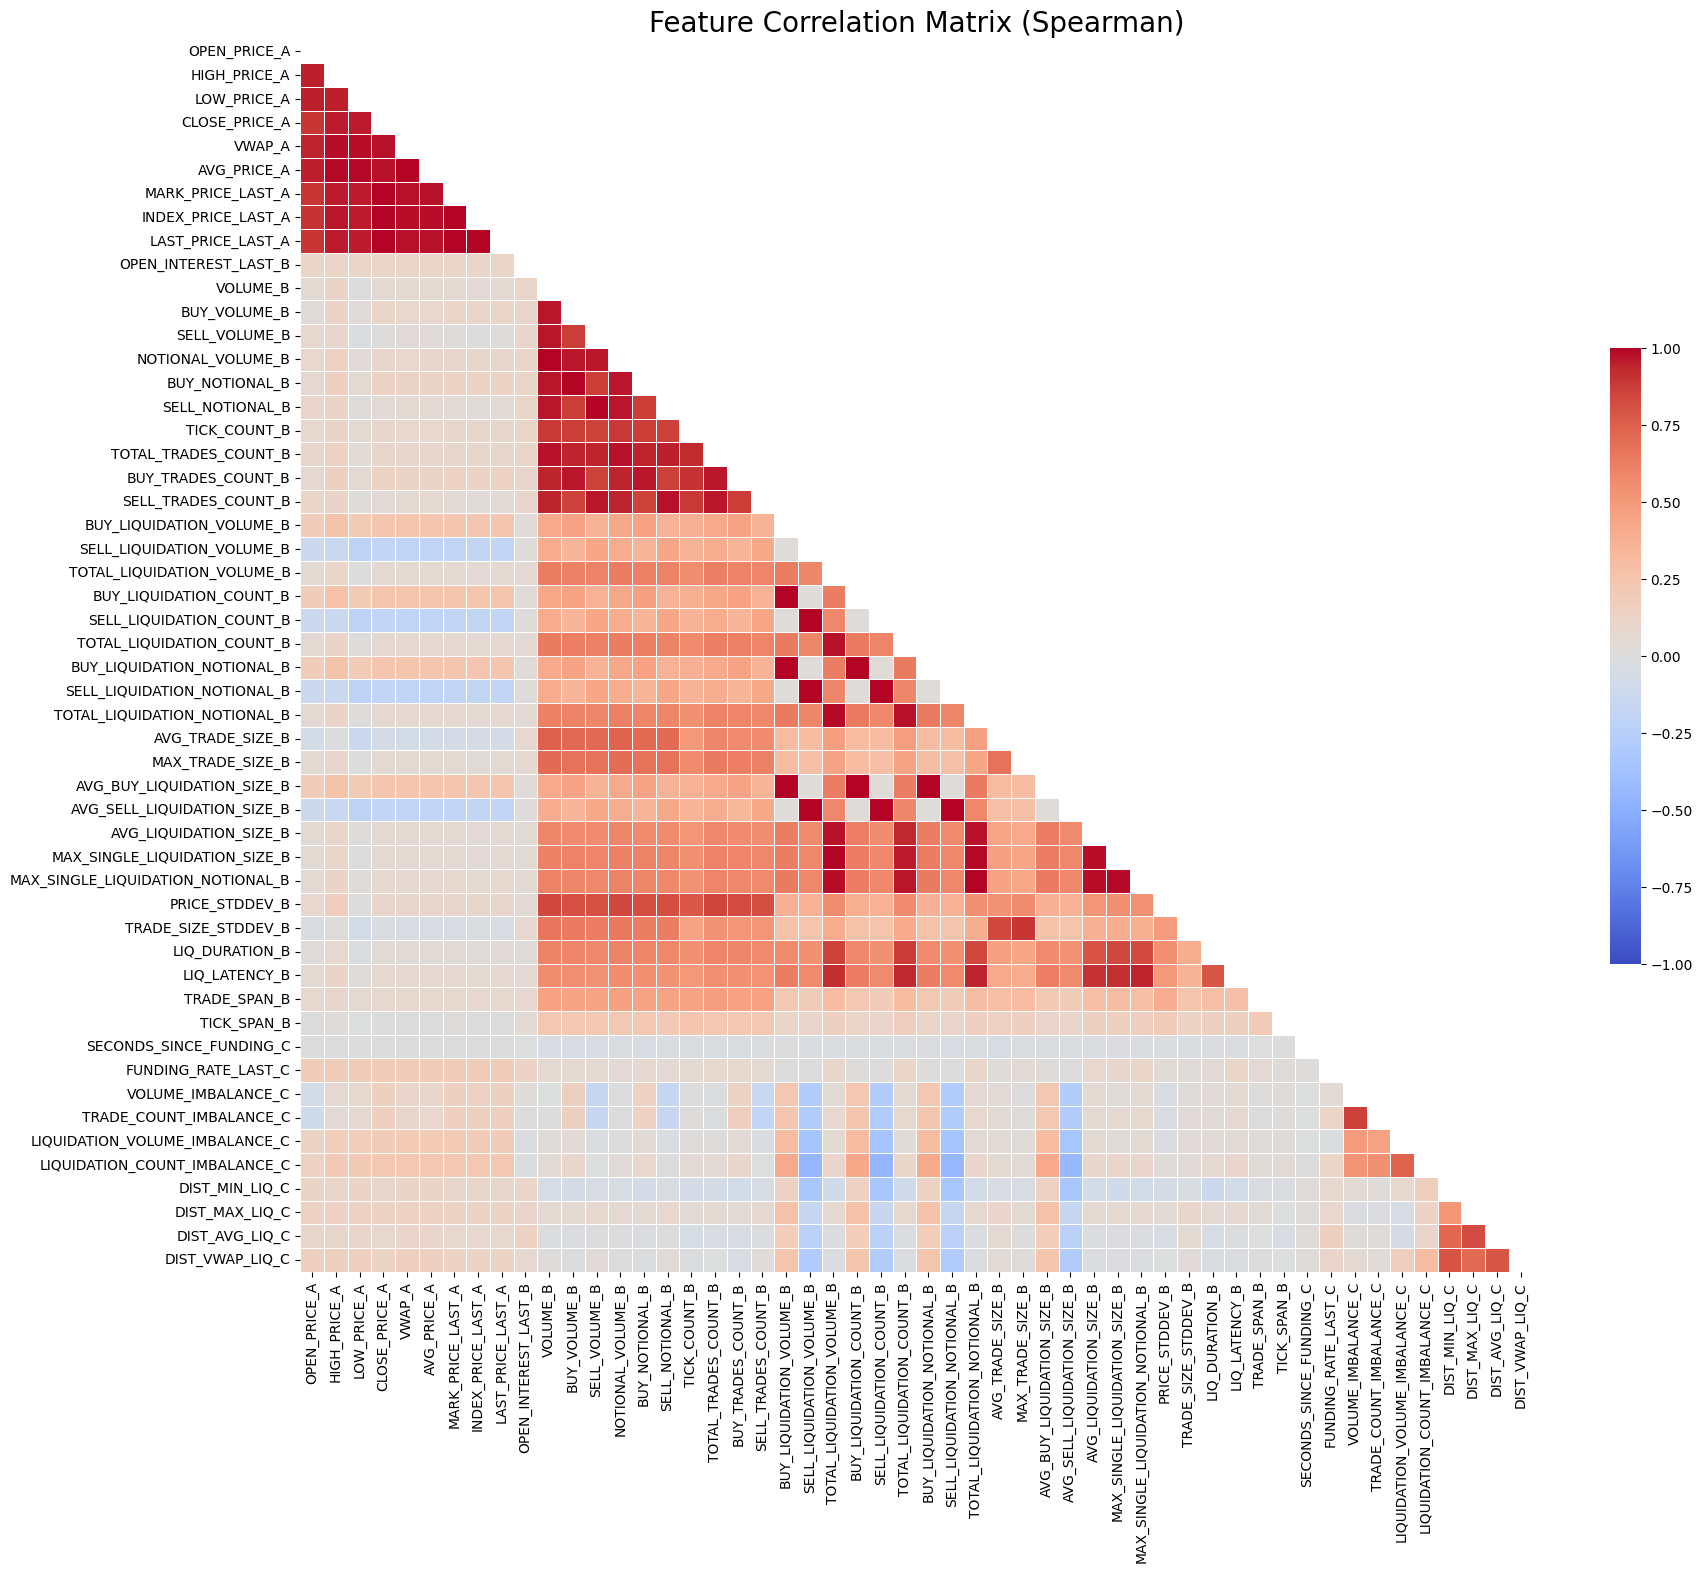


--- HIGHLY CORRELATED PAIRS (>0.95) ---
SELL_LIQUIDATION_NOTIONAL_B  SELL_LIQUIDATION_VOLUME_B      0.999976
SELL_LIQUIDATION_VOLUME_B    SELL_LIQUIDATION_NOTIONAL_B    0.999976
BUY_LIQUIDATION_NOTIONAL_B   BUY_LIQUIDATION_VOLUME_B       0.999963
BUY_LIQUIDATION_VOLUME_B     BUY_LIQUIDATION_NOTIONAL_B     0.999963
LAST_PRICE_LAST_A            CLOSE_PRICE_A                  0.999950
CLOSE_PRICE_A                LAST_PRICE_LAST_A              0.999950
AVG_PRICE_A                  VWAP_A                         0.999632
VWAP_A                       AVG_PRICE_A                    0.999632
INDEX_PRICE_LAST_A           MARK_PRICE_LAST_A              0.999442
MARK_PRICE_LAST_A            INDEX_PRICE_LAST_A             0.999442
                             LAST_PRICE_LAST_A              0.999357
LAST_PRICE_LAST_A            MARK_PRICE_LAST_A              0.999357
MARK_PRICE_LAST_A            CLOSE_PRICE_A                  0.999309
CLOSE_PRICE_A                MARK_PRICE_LAST_A              0.

In [107]:
# ==========================================
# VISUAL ANALYSIS: CORRELATION HEATMAP
# ==========================================

# 1. Filter for Numeric Columns Only (Safety)
# We exclude the strings (Symbol/Exchange) from calculation
numeric_df = df_final.select_dtypes(include=[np.number])

# 2. Compute Correlation (Spearman)
# Spearman is robust to outliers and captures monotonic relationships better than Pearson
print("Computing Spearman Correlation Matrix...")
corr_matrix = numeric_df.corr(method='spearman')

# 3. Plotting
plt.figure(figsize=(20, 16))

# We use a mask to hide the upper triangle (it's symmetrical, so redundant)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Clustermap vs Heatmap
# A standard heatmap is good, but a 'clustermap' automatically reorders 
# columns to put similar features next to each other.
# We'll use a standard heatmap first for raw inspection.
sns.heatmap(
    corr_matrix, 
    mask=mask,
    cmap='coolwarm',     # Red = High Positive, Blue = High Negative
    center=0,            # Center colormap at 0 correlation
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5},
    vmin=-1, vmax=1      # Fix scale to -1 to 1
)

plt.title('Feature Correlation Matrix (Spearman)', fontsize=20)
plt.yticks(rotation=0)
plt.show()

# 4. Numeric Output: Identify Top Collinear Pairs
# This prints the pairs with correlation > 0.95 (Candidates for dropping)
print("\n--- HIGHLY CORRELATED PAIRS (>0.95) ---")
# Unstack the matrix to get pairs
corr_pairs = corr_matrix.abs().unstack()
# Filter self-correlations and duplicates
corr_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1.0] # Remove self correlation

# Show top 20
print(corr_pairs.head(20))

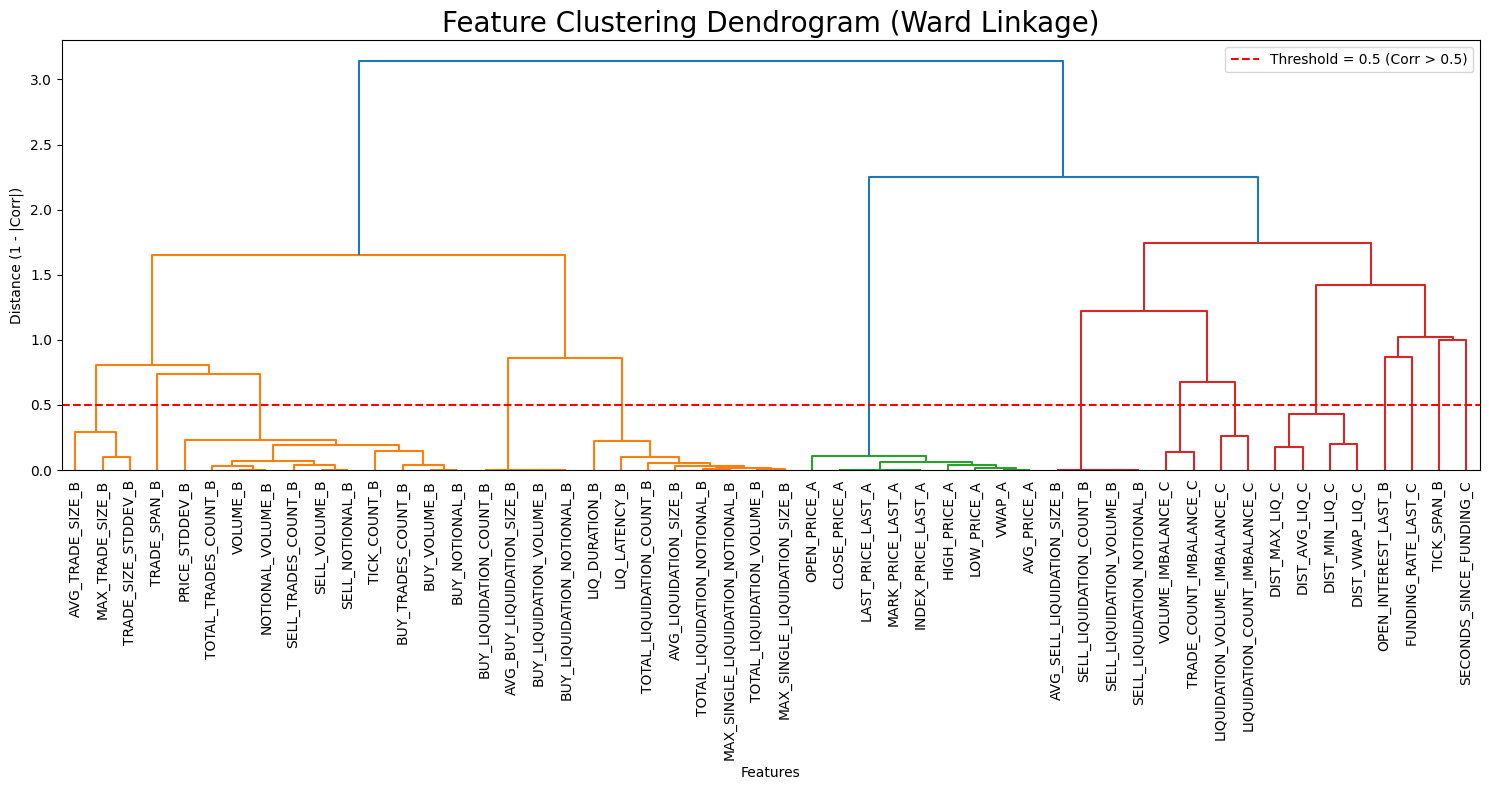

In [108]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==========================================
# HIERARCHICAL CLUSTERING ANALYSIS
# ==========================================

# 1. Prepare Data
# Select only numeric features (exclude Symbol/Timestamp index)
X = df_final.select_dtypes(include=[np.number])

# 2. Calculate Correlation Distance
# We use Spearman (Rank) correlation
corr = X.corr(method='spearman')

# Convert correlation to "distance"
# Distance is low (close) if correlation is high.
# We use absolute correlation because -0.9 is just as strong a relationship as 0.9.
distance_matrix = 1 - np.abs(corr)

# 3. Perform Clustering (Linkage)
# Ward's method minimizes the variance within clusters being merged.
# It tends to create compact, even-sized clusters.
# We use squareform to convert the matrix to the format scipy expects.
from scipy.spatial.distance import squareform
linkage_matrix = sch.linkage(squareform(distance_matrix), method='ward')

# 4. Plot Dendrogram
plt.figure(figsize=(15, 8))
dendrogram = sch.dendrogram(
    linkage_matrix,
    labels=X.columns,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title('Feature Clustering Dendrogram (Ward Linkage)', fontsize=20)
plt.xlabel('Features')
plt.ylabel('Distance (1 - |Corr|)')
plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold = 0.5 (Corr > 0.5)')
plt.legend()
plt.tight_layout()
plt.show()

In [109]:
from scipy.cluster.hierarchy import fcluster

# ==========================================
# CREATE CLUSTER ASSIGNMENTS
# ==========================================

# 1. Define Threshold
# Distance = 0.5 implies we group features with > 0.5 correlation together.
# Adjust this if you want fewer, larger clusters (increase t) or many small clusters (decrease t).
threshold = 0.5 

# 2. Form Flat Clusters
cluster_labels = fcluster(linkage_matrix, t=threshold, criterion='distance')

# 3. Organize into a DataFrame
cluster_df = pd.DataFrame({
    'Feature': X.columns,
    'Cluster_ID': cluster_labels
})

# 4. Sort by Cluster to see the groups
cluster_df = cluster_df.sort_values('Cluster_ID')

print(f"--- CLUSTER ASSIGNMENTS (Threshold={threshold}) ---")
print(f"Total Clusters Found: {cluster_df['Cluster_ID'].nunique()}")
print("\nSample Clusters:")

# Print features in each cluster
for cluster_id in sorted(cluster_df['Cluster_ID'].unique()):
    features = cluster_df[cluster_df['Cluster_ID'] == cluster_id]['Feature'].tolist()
    # Only print if it's a group (more than 1 feature) to save space
    if len(features) > 1:
        print(f"Cluster {cluster_id}: {features}")

--- CLUSTER ASSIGNMENTS (Threshold=0.5) ---
Total Clusters Found: 14

Sample Clusters:
Cluster 1: ['MAX_TRADE_SIZE_B', 'AVG_TRADE_SIZE_B', 'TRADE_SIZE_STDDEV_B']
Cluster 2: ['SELL_VOLUME_B', 'VOLUME_B', 'BUY_VOLUME_B', 'SELL_NOTIONAL_B', 'NOTIONAL_VOLUME_B', 'TOTAL_TRADES_COUNT_B', 'TICK_COUNT_B', 'SELL_TRADES_COUNT_B', 'BUY_TRADES_COUNT_B', 'PRICE_STDDEV_B', 'BUY_NOTIONAL_B']
Cluster 4: ['BUY_LIQUIDATION_COUNT_B', 'AVG_BUY_LIQUIDATION_SIZE_B', 'BUY_LIQUIDATION_VOLUME_B', 'BUY_LIQUIDATION_NOTIONAL_B']
Cluster 5: ['TOTAL_LIQUIDATION_NOTIONAL_B', 'AVG_LIQUIDATION_SIZE_B', 'TOTAL_LIQUIDATION_VOLUME_B', 'TOTAL_LIQUIDATION_COUNT_B', 'LIQ_DURATION_B', 'MAX_SINGLE_LIQUIDATION_SIZE_B', 'LIQ_LATENCY_B', 'MAX_SINGLE_LIQUIDATION_NOTIONAL_B']
Cluster 6: ['LAST_PRICE_LAST_A', 'HIGH_PRICE_A', 'AVG_PRICE_A', 'MARK_PRICE_LAST_A', 'INDEX_PRICE_LAST_A', 'CLOSE_PRICE_A', 'LOW_PRICE_A', 'OPEN_PRICE_A', 'VWAP_A']
Cluster 7: ['AVG_SELL_LIQUIDATION_SIZE_B', 'SELL_LIQUIDATION_COUNT_B', 'SELL_LIQUIDATION_VOLUM

In [110]:
from scipy.cluster.hierarchy import fcluster

# ==========================================
# CREATE CLUSTER ASSIGNMENTS
# ==========================================

# 1. Define Threshold
# Distance = 0.5 implies we group features with > 0.5 correlation together.
# Adjust this if you want fewer, larger clusters (increase t) or many small clusters (decrease t).
threshold = 0.3

# 2. Form Flat Clusters
cluster_labels = fcluster(linkage_matrix, t=threshold, criterion='distance')

# 3. Organize into a DataFrame
cluster_df = pd.DataFrame({
    'Feature': X.columns,
    'Cluster_ID': cluster_labels
})

# 4. Sort by Cluster to see the groups
cluster_df = cluster_df.sort_values('Cluster_ID')

print(f"--- CLUSTER ASSIGNMENTS (Threshold={threshold}) ---")
print(f"Total Clusters Found: {cluster_df['Cluster_ID'].nunique()}")
print("\nSample Clusters:")

# Print features in each cluster
for cluster_id in sorted(cluster_df['Cluster_ID'].unique()):
    features = cluster_df[cluster_df['Cluster_ID'] == cluster_id]['Feature'].tolist()
    # Only print if it's a group (more than 1 feature) to save space
    if len(features) > 1:
        print(f"Cluster {cluster_id}: {features}")

--- CLUSTER ASSIGNMENTS (Threshold=0.3) ---
Total Clusters Found: 15

Sample Clusters:
Cluster 1: ['MAX_TRADE_SIZE_B', 'AVG_TRADE_SIZE_B', 'TRADE_SIZE_STDDEV_B']
Cluster 2: ['SELL_VOLUME_B', 'VOLUME_B', 'BUY_VOLUME_B', 'SELL_NOTIONAL_B', 'NOTIONAL_VOLUME_B', 'TOTAL_TRADES_COUNT_B', 'TICK_COUNT_B', 'SELL_TRADES_COUNT_B', 'BUY_TRADES_COUNT_B', 'PRICE_STDDEV_B', 'BUY_NOTIONAL_B']
Cluster 4: ['BUY_LIQUIDATION_COUNT_B', 'AVG_BUY_LIQUIDATION_SIZE_B', 'BUY_LIQUIDATION_VOLUME_B', 'BUY_LIQUIDATION_NOTIONAL_B']
Cluster 5: ['TOTAL_LIQUIDATION_NOTIONAL_B', 'AVG_LIQUIDATION_SIZE_B', 'TOTAL_LIQUIDATION_VOLUME_B', 'TOTAL_LIQUIDATION_COUNT_B', 'LIQ_DURATION_B', 'MAX_SINGLE_LIQUIDATION_SIZE_B', 'LIQ_LATENCY_B', 'MAX_SINGLE_LIQUIDATION_NOTIONAL_B']
Cluster 6: ['LAST_PRICE_LAST_A', 'HIGH_PRICE_A', 'AVG_PRICE_A', 'MARK_PRICE_LAST_A', 'INDEX_PRICE_LAST_A', 'CLOSE_PRICE_A', 'LOW_PRICE_A', 'OPEN_PRICE_A', 'VWAP_A']
Cluster 7: ['AVG_SELL_LIQUIDATION_SIZE_B', 'SELL_LIQUIDATION_COUNT_B', 'SELL_LIQUIDATION_VOLUM

In [ ]:
import pandas as pd
from scipy.cluster.hierarchy import fcluster

# ==========================================
# FINAL CLUSTER ASSIGNMENT (Threshold = 0.3)
# ==========================================

# 1. Re-run Clustering with T=0.3
threshold = 0.1
cluster_labels = fcluster(linkage_matrix, t=threshold, criterion='distance')

# 2. Create the Final Map
feat_cluster_map = pd.DataFrame({
    'Feature': X.columns,
    'Cluster_ID': cluster_labels
})

# 3. Save/Print for Reference
print(f"--- FINAL CLUSTER CONFIGURATION (T={threshold}) ---")
print(f"Total Clusters: {feat_cluster_map['Cluster_ID'].nunique()}")

# Sort by cluster for easy reading
feat_cluster_map = feat_cluster_map.sort_values('Cluster_ID')

# Create a dictionary for quick lookups later {Feature: Cluster_ID}
feature_to_cluster = dict(zip(feat_cluster_map['Feature'], feat_cluster_map['Cluster_ID']))

# Show the breakdown
for cid in sorted(feat_cluster_map['Cluster_ID'].unique()):
    feats = feat_cluster_map[feat_cluster_map['Cluster_ID'] == cid]['Feature'].tolist()
    print(f"\nCluster {cid} ({len(feats)} features):")
    print(feats)

--- FINAL CLUSTER CONFIGURATION (T=0.3) ---
Total Clusters: 15

Cluster 1 (3 features):
['MAX_TRADE_SIZE_B', 'AVG_TRADE_SIZE_B', 'TRADE_SIZE_STDDEV_B']

Cluster 2 (11 features):
['SELL_VOLUME_B', 'VOLUME_B', 'BUY_VOLUME_B', 'SELL_NOTIONAL_B', 'NOTIONAL_VOLUME_B', 'TOTAL_TRADES_COUNT_B', 'TICK_COUNT_B', 'SELL_TRADES_COUNT_B', 'BUY_TRADES_COUNT_B', 'PRICE_STDDEV_B', 'BUY_NOTIONAL_B']

Cluster 3 (1 features):
['TRADE_SPAN_B']

Cluster 4 (4 features):
['BUY_LIQUIDATION_COUNT_B', 'AVG_BUY_LIQUIDATION_SIZE_B', 'BUY_LIQUIDATION_VOLUME_B', 'BUY_LIQUIDATION_NOTIONAL_B']

Cluster 5 (8 features):
['TOTAL_LIQUIDATION_NOTIONAL_B', 'AVG_LIQUIDATION_SIZE_B', 'TOTAL_LIQUIDATION_VOLUME_B', 'TOTAL_LIQUIDATION_COUNT_B', 'LIQ_DURATION_B', 'MAX_SINGLE_LIQUIDATION_SIZE_B', 'LIQ_LATENCY_B', 'MAX_SINGLE_LIQUIDATION_NOTIONAL_B']

Cluster 6 (9 features):
['LAST_PRICE_LAST_A', 'HIGH_PRICE_A', 'AVG_PRICE_A', 'MARK_PRICE_LAST_A', 'INDEX_PRICE_LAST_A', 'CLOSE_PRICE_A', 'LOW_PRICE_A', 'OPEN_PRICE_A', 'VWAP_A']

Clus

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# ==============================================================================
# ENGINE: CLUSTERED PERMUTATION IMPORTANCE (MDA)
# ==============================================================================
def get_clustered_mda_scores(X, y, feature_to_cluster, model_params=None):
    """
    1. Fits RF on Train (First 70%).
    2. Scores on Validation (Last 30%).
    3. Shuffles each Cluster in Validation and measures score drop.
    """
    # Default light params for speed
    if model_params is None:
        model_params = {'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1, 'random_state': 42}
    
    # A. Time-Series Split (No Shuffling!)
    # We strictly respect time. Train on past, test on future.
    split_idx = int(len(X) * 0.70)
    X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # B. Fit the Model
    clf = RandomForestClassifier(**model_params)
    clf.fit(X_train, y_train)
    
    # C. Get Baseline Score (Validation Log Loss)
    # We use predict_proba for Log Loss
    base_probs = clf.predict_proba(X_val)
    # Handle multiclass or binary safely
    base_score = log_loss(y_val, base_probs, labels=clf.classes_)
    
    # D. Permutation Loop (Per Cluster)
    scores = {}
    unique_clusters = sorted(list(set(feature_to_cluster.values())))
    
    for cid in unique_clusters:
        # 1. Identify features in this cluster
        cluster_feats = [f for f, c in feature_to_cluster.items() if c == cid]
        if not cluster_feats: continue
            
        # 2. Create a copy of X_val to wreck
        X_val_shuffled = X_val.copy()
        
        # 3. Shuffle ALL features in this cluster (preserving row counts, just shuffling values)
        # We start with the values of the columns
        shuffled_values = X_val[cluster_feats].values.copy()
        # Shuffle along the first axis (rows)
        np.random.shuffle(shuffled_values)
        # Assign back
        X_val_shuffled[cluster_feats] = shuffled_values
        
        # 4. Score the broken dataset
        shuffled_probs = clf.predict_proba(X_val_shuffled)
        shuffled_score = log_loss(y_val, shuffled_probs, labels=clf.classes_)
        
        # 5. Calculate Importance
        # If LogLoss goes UP (bad), Importance is POSITIVE.
        importance = shuffled_score - base_score
        scores[cid] = importance
        
    return scores

--- ALIGNING FEATURES AND TARGETS ---


In [113]:
# 3. DROP NON-NUMERIC COLUMNS from X
# Random Forest cannot handle 'SYMBOL' or 'EXCHANGE' strings.
# We select only numeric types (float/int).
X_numeric = X_full.select_dtypes(include=[np.number])

# Sanity Check
print(f"Aligned Rows: {len(X_numeric)}")
print(f"Feature Count: {X_numeric.shape[1]} (Numeric Only)")
print(f"Targets: {y_full.columns.tolist()}")

Aligned Rows: 46544
Feature Count: 52 (Numeric Only)
Targets: ['target_both_100_1_24_tb', 'target_long_001_24_std', 'target_short_001_24_std']


In [114]:
# 4. Update Cluster Map (Safety Step)
# Ensure our 'feature_to_cluster' map doesn't contain columns we just dropped (strings)
feature_to_cluster_clean = {k: v for k, v in feature_to_cluster.items() if k in X_numeric.columns}


In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import TimeSeriesSplit

# ==============================================================================
# ENGINE: ROBUST CLUSTERED MDA (WALK-FORWARD)
# ==============================================================================
def get_robust_clustered_mda(X, y, feature_to_cluster, n_splits=3, purge_size=24):
    """
    Args:
        purge_size: 24 (Matches your Triple Barrier Expiry)
    """
    # 1. Setup Model (Light RF)
    model_params = {'n_estimators': 150, 'max_depth': 5, 'n_jobs': -1, 'random_state': 42}
    
    # 2. Walk-Forward Splitter
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_scores = []
    
    print(f"Starting {n_splits}-Fold Walk-Forward MDA (Purge={purge_size})...")
    
    for fold_idx, (train_indices, val_indices) in enumerate(tscv.split(X)):
        
        # --- PURGING ---
        # Skip the first 'purge_size' rows of validation to prevent overlap leakage
        if len(val_indices) <= purge_size:
            continue
        val_indices = val_indices[purge_size:]
        
        # Split
        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]
        
        # Fit
        clf = RandomForestClassifier(**model_params)
        clf.fit(X_train, y_train)
        
        # Base Score (Log Loss)
        base_probs = clf.predict_proba(X_val)
        base_score = log_loss(y_val, base_probs, labels=clf.classes_)
        
        # --- CLUSTER PERMUTATION ---
        fold_importances = {}
        unique_clusters = sorted(list(set(feature_to_cluster.values())))
        
        for cid in unique_clusters:
            # Get features for this cluster that exist in X
            cluster_feats = [f for f, c in feature_to_cluster.items() if c == cid and f in X.columns]
            if not cluster_feats: continue
            
            # Shuffle
            X_val_shuffled = X_val.copy()
            shuffled_vals = X_val[cluster_feats].values.copy()
            np.random.shuffle(shuffled_vals)
            X_val_shuffled[cluster_feats] = shuffled_vals
            
            # Score Drop
            shuffled_probs = clf.predict_proba(X_val_shuffled)
            shuffled_score = log_loss(y_val, shuffled_probs, labels=clf.classes_)
            
            fold_importances[cid] = shuffled_score - base_score
            
        fold_scores.append(fold_importances)
        print(f"  Fold {fold_idx+1} Base Loss: {base_score:.4f}")

    # Aggregate
    return pd.DataFrame(fold_scores).mean().to_dict()


In [116]:

# ==============================================================================
# EXECUTION LOOP
# ==============================================================================
mda_results = {}

for target_col in y_full.columns:
    print(f"\n--- Processing Target: {target_col} ---")
    
    # Prepare Y (Drop NaNs)
    y_series = y_full[target_col]
    valid_mask = ~y_series.isna()
    
    # Filter X and Y to match valid targets
    X_clean = X_numeric[valid_mask]
    y_clean = y_series[valid_mask]
    
    # Run MDA
    # Note: purge_size=24 matches your expiry parameters
    scores = get_robust_clustered_mda(
        X_clean, 
        y_clean, 
        feature_to_cluster_clean, 
        n_splits=3, 
        purge_size=24
    )
    
    mda_results[target_col] = scores



--- Processing Target: target_both_100_1_24_tb ---
Starting 3-Fold Walk-Forward MDA (Purge=24)...
  Fold 1 Base Loss: 0.6992
  Fold 2 Base Loss: 0.6672
  Fold 3 Base Loss: 0.6667

--- Processing Target: target_long_001_24_std ---
Starting 3-Fold Walk-Forward MDA (Purge=24)...
  Fold 1 Base Loss: 0.6728
  Fold 2 Base Loss: 0.6553
  Fold 3 Base Loss: 0.6522

--- Processing Target: target_short_001_24_std ---
Starting 3-Fold Walk-Forward MDA (Purge=24)...
  Fold 1 Base Loss: 0.6803
  Fold 2 Base Loss: 0.6560
  Fold 3 Base Loss: 0.6413


In [117]:

# ==============================================================================
# FINAL REPORT
# ==============================================================================
df_mda = pd.DataFrame(mda_results)
df_mda.index.name = "Cluster_ID"
df_mda = df_mda.sort_index()

print("\n--- FINAL CLUSTER IMPORTANCE (Log Loss Decrease) ---")
print(df_mda)



--- FINAL CLUSTER IMPORTANCE (Log Loss Decrease) ---
            target_both_100_1_24_tb  target_long_001_24_std  \
Cluster_ID                                                    
1                          0.000299                0.000182   
2                          0.004003                0.004091   
3                         -0.000030               -0.000012   
4                          0.012055                0.002337   
5                          0.002281               -0.000040   
6                          0.008937                0.002794   
7                          0.003465                0.000703   
8                          0.003696               -0.000008   
9                          0.003785               -0.000668   
10                        -0.000043               -0.000020   
11                         0.000818                0.000373   
12                         0.000080                0.000130   
13                         0.000042                0.000051   
1

In [ ]:

# Check for "Dead" Clusters (Negative or Zero score across all targets)
df_mda['Total_Importance'] = df_mda.sum(axis=1)
dead_clusters = df_mda[df_mda['Total_Importance'] <= 0].index.tolist()
if dead_clusters:
    print(f"\n[!] Candidate Clusters for Removal (Zero/Neg Importance): {dead_clusters}")
else:
    print("\n[+] All clusters contribute signal to at least one target.")


[!] Candidate Clusters for Removal (Zero/Neg Importance): [3, 13]


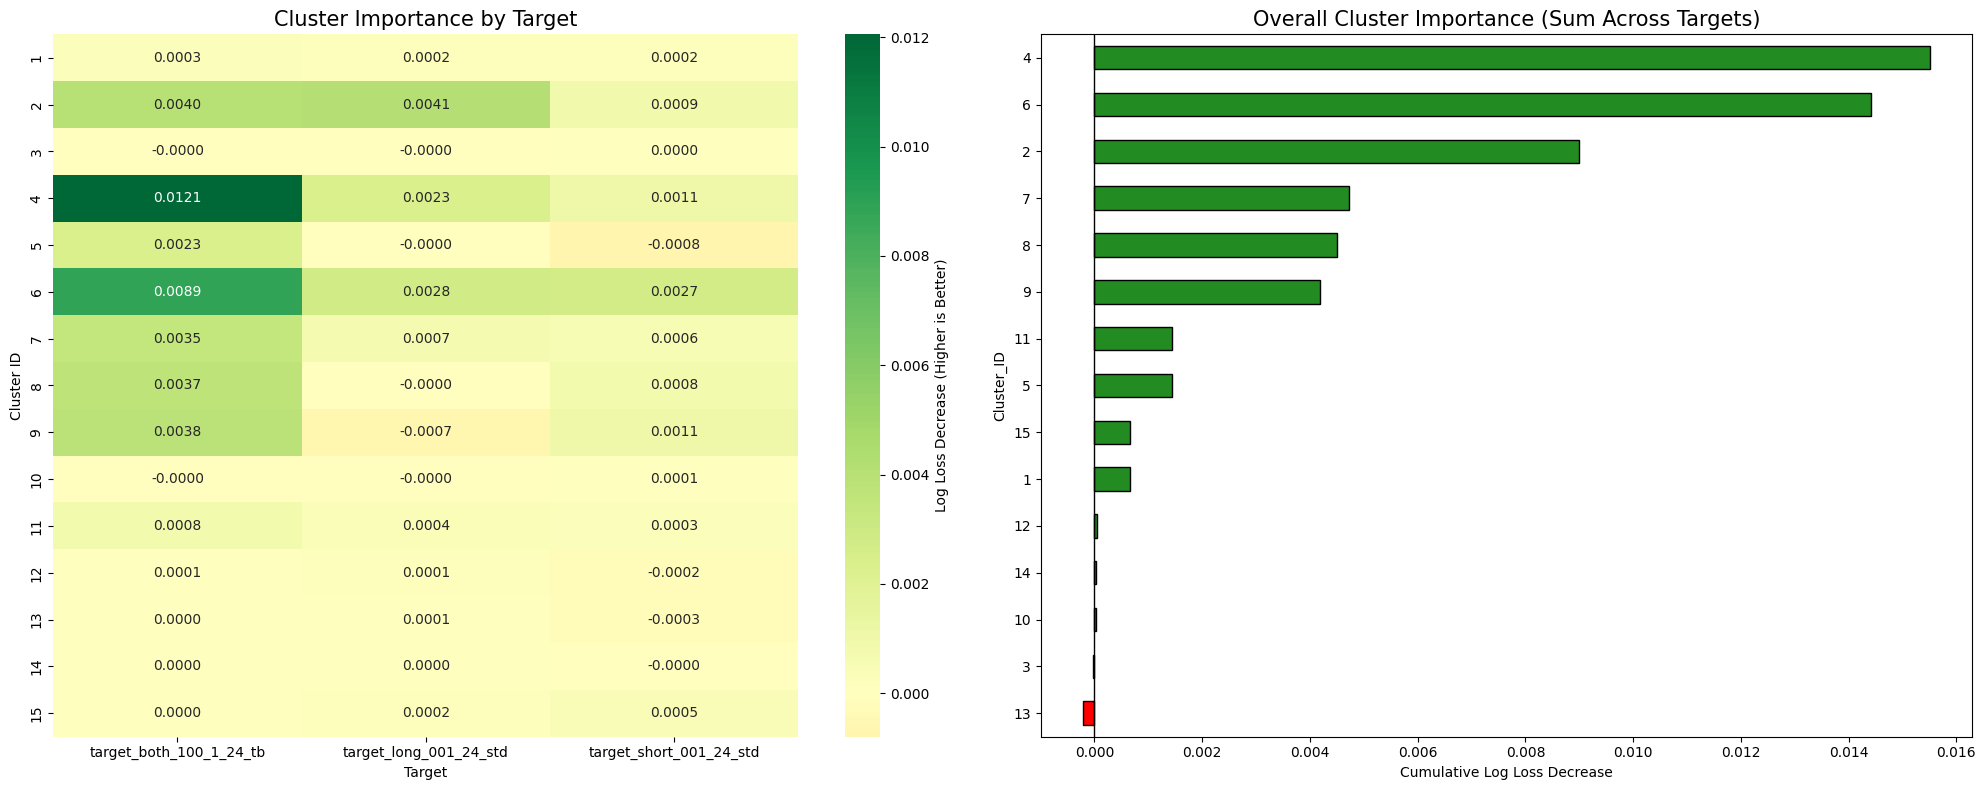


--- DECISION REPORT ---
🏆 MVP Cluster: Cluster 4 (Highest Total Signal)
⚠️  Harmful Clusters (Negative Score - REMOVE THESE): [13, 3]
💤 Weak/Noise Clusters (Near Zero Impact): [10, 14, 12]


In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==============================================================================
# VISUALIZE MDA RESULTS
# ==============================================================================

# 1. Setup the figure layout (2 plots: Heatmap & Bar Chart)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- PLOT A: HEATMAP (Target Specificity) ---
# This shows exactly which cluster drives which target signal.
sns.heatmap(
    df_mda.drop(columns=['Total_Importance'], errors='ignore'), # Exclude total if it exists
    annot=True,
    fmt=".4f",
    cmap="RdYlGn",   # Red = Bad (Negative), Green = Good (Positive)
    center=0,        # Center the color scale at 0 to highlight negative scores
    ax=axes[0],
    cbar_kws={'label': 'Log Loss Decrease (Higher is Better)'}
)
axes[0].set_title('Cluster Importance by Target', fontsize=15)
axes[0].set_ylabel('Cluster ID')
axes[0].set_xlabel('Target')

# --- PLOT B: RANKED BAR CHART (Overall Power) ---
# Calculate Total Importance across all targets to find the "MVPs"
total_importance = df_mda.drop(columns=['Total_Importance'], errors='ignore').sum(axis=1).sort_values(ascending=True)

# Color bars based on Positive (Green) or Negative (Red) impact
colors = ['red' if x < 0 else 'forestgreen' for x in total_importance.values]

total_importance.plot(kind='barh', ax=axes[1], color=colors, edgecolor='black')
axes[1].axvline(0, color='black', linewidth=1) # Zero line
axes[1].set_title('Overall Cluster Importance (Sum Across Targets)', fontsize=15)
axes[1].set_xlabel('Cumulative Log Loss Decrease')

plt.tight_layout()
plt.show()

# ==============================================================================
# TEXT SUMMARY
# ==============================================================================
print("\n--- DECISION REPORT ---")
# 1. Best Cluster
best_cluster = total_importance.idxmax()
print(f"🏆 MVP Cluster: Cluster {best_cluster} (Highest Total Signal)")

# 2. Worst Clusters (Negative Impact)
negative_clusters = total_importance[total_importance < 0].index.tolist()
if negative_clusters:
    print(f"⚠️  Harmful Clusters (Negative Score - REMOVE THESE): {negative_clusters}")
else:
    print("✅ No clusters were explicitly harmful (all > 0).")

# 3. Useless Clusters (Near Zero)
# Clusters that add less than 0.0001 total log loss improvement are basically noise.
useless_clusters = total_importance[(total_importance >= 0) & (total_importance < 1e-4)].index.tolist()
if useless_clusters:
    print(f"💤 Weak/Noise Clusters (Near Zero Impact): {useless_clusters}")

In [137]:
df_mda.head()

,target_both_100_1_24_tb,target_long_001_24_std,target_short_001_24_std,Total_Importance
Cluster_ID,,,,
1,0.000299,0.000182,0.000179,0.000660
2,0.004003,0.004091,0.000896,0.008991
3,-0.000030,-0.000012,0.000020,-0.000023
4,0.012055,0.002337,0.001113,0.015505
5,0.002281,-0.000040,-0.000796,0.001445


In [134]:
df_mda.index

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='Cluster_ID')

In [144]:
ids = [4, 6, 2, 7, 8, 9]

out = (
    cluster_df[cluster_df['Cluster_ID'].isin(ids)]
    .merge(
        df_mda,
        left_on='Cluster_ID',
        right_index=True,
        how='inner'
    )
    .sort_values('Total_Importance', ascending=False)
)


In [145]:
out

,Feature,Cluster_ID,target_both_100_1_24_tb,target_long_001_24_std,target_short_001_24_std,Total_Importance
31,AVG_BUY_LIQUIDATION_SIZE_B,4,0.012055,0.002337,0.001113,0.015505
20,BUY_LIQUIDATION_VOLUME_B,4,0.012055,0.002337,0.001113,0.015505
26,BUY_LIQUIDATION_NOTIONAL_B,4,0.012055,0.002337,0.001113,0.015505
23,BUY_LIQUIDATION_COUNT_B,4,0.012055,0.002337,0.001113,0.015505
8,LAST_PRICE_LAST_A,6,0.008937,0.002794,0.002686,0.014417
6,MARK_PRICE_LAST_A,6,0.008937,0.002794,0.002686,0.014417
5,AVG_PRICE_A,6,0.008937,0.002794,0.002686,0.014417
1,HIGH_PRICE_A,6,0.008937,0.002794,0.002686,0.014417
4,VWAP_A,6,0.008937,0.002794,0.002686,0.014417
0,OPEN_PRICE_A,6,0.008937,0.002794,0.002686,0.014417


In [ ]:
cluster_df[cluster_df['Cluster_ID'].isin([4, 6, 2, 7, 9])]


,Feature,Cluster_ID
12,SELL_VOLUME_B,2
10,VOLUME_B,2
11,BUY_VOLUME_B,2
15,SELL_NOTIONAL_B,2
13,NOTIONAL_VOLUME_B,2
17,TOTAL_TRADES_COUNT_B,2
16,TICK_COUNT_B,2
19,SELL_TRADES_COUNT_B,2
18,BUY_TRADES_COUNT_B,2
36,PRICE_STDDEV_B,2


In [127]:
cluster_df[cluster_df['Cluster_ID'].isin([12, 14, 10, 3, 13])]


,Feature,Cluster_ID
40,TRADE_SPAN_B,3
50,DIST_AVG_LIQ_C,10
49,DIST_MAX_LIQ_C,10
9,OPEN_INTEREST_LAST_B,12
43,FUNDING_RATE_LAST_C,13
41,TICK_SPAN_B,14


--- FINAL CLUSTER CONFIGURATION (T=0.1) ---
Total Clusters: 26

Cluster 1 (1 features):
['MAX_TRADE_SIZE_B']

Cluster 2 (1 features):
['TRADE_SIZE_STDDEV_B']

Cluster 3 (1 features):
['AVG_TRADE_SIZE_B']

Cluster 4 (6 features):
['SELL_VOLUME_B', 'SELL_TRADES_COUNT_B', 'TOTAL_TRADES_COUNT_B', 'SELL_NOTIONAL_B', 'NOTIONAL_VOLUME_B', 'VOLUME_B']

Cluster 5 (3 features):
['BUY_NOTIONAL_B', 'BUY_TRADES_COUNT_B', 'BUY_VOLUME_B']

Cluster 6 (1 features):
['TICK_COUNT_B']

Cluster 7 (1 features):
['PRICE_STDDEV_B']

Cluster 8 (1 features):
['TRADE_SPAN_B']

Cluster 9 (4 features):
['BUY_LIQUIDATION_COUNT_B', 'AVG_BUY_LIQUIDATION_SIZE_B', 'BUY_LIQUIDATION_VOLUME_B', 'BUY_LIQUIDATION_NOTIONAL_B']

Cluster 10 (7 features):
['TOTAL_LIQUIDATION_NOTIONAL_B', 'AVG_LIQUIDATION_SIZE_B', 'TOTAL_LIQUIDATION_VOLUME_B', 'TOTAL_LIQUIDATION_COUNT_B', 'LIQ_LATENCY_B', 'MAX_SINGLE_LIQUIDATION_NOTIONAL_B', 'MAX_SINGLE_LIQUIDATION_SIZE_B']

Cluster 11 (1 features):
['LIQ_DURATION_B']

Cluster 12 (8 features):
[

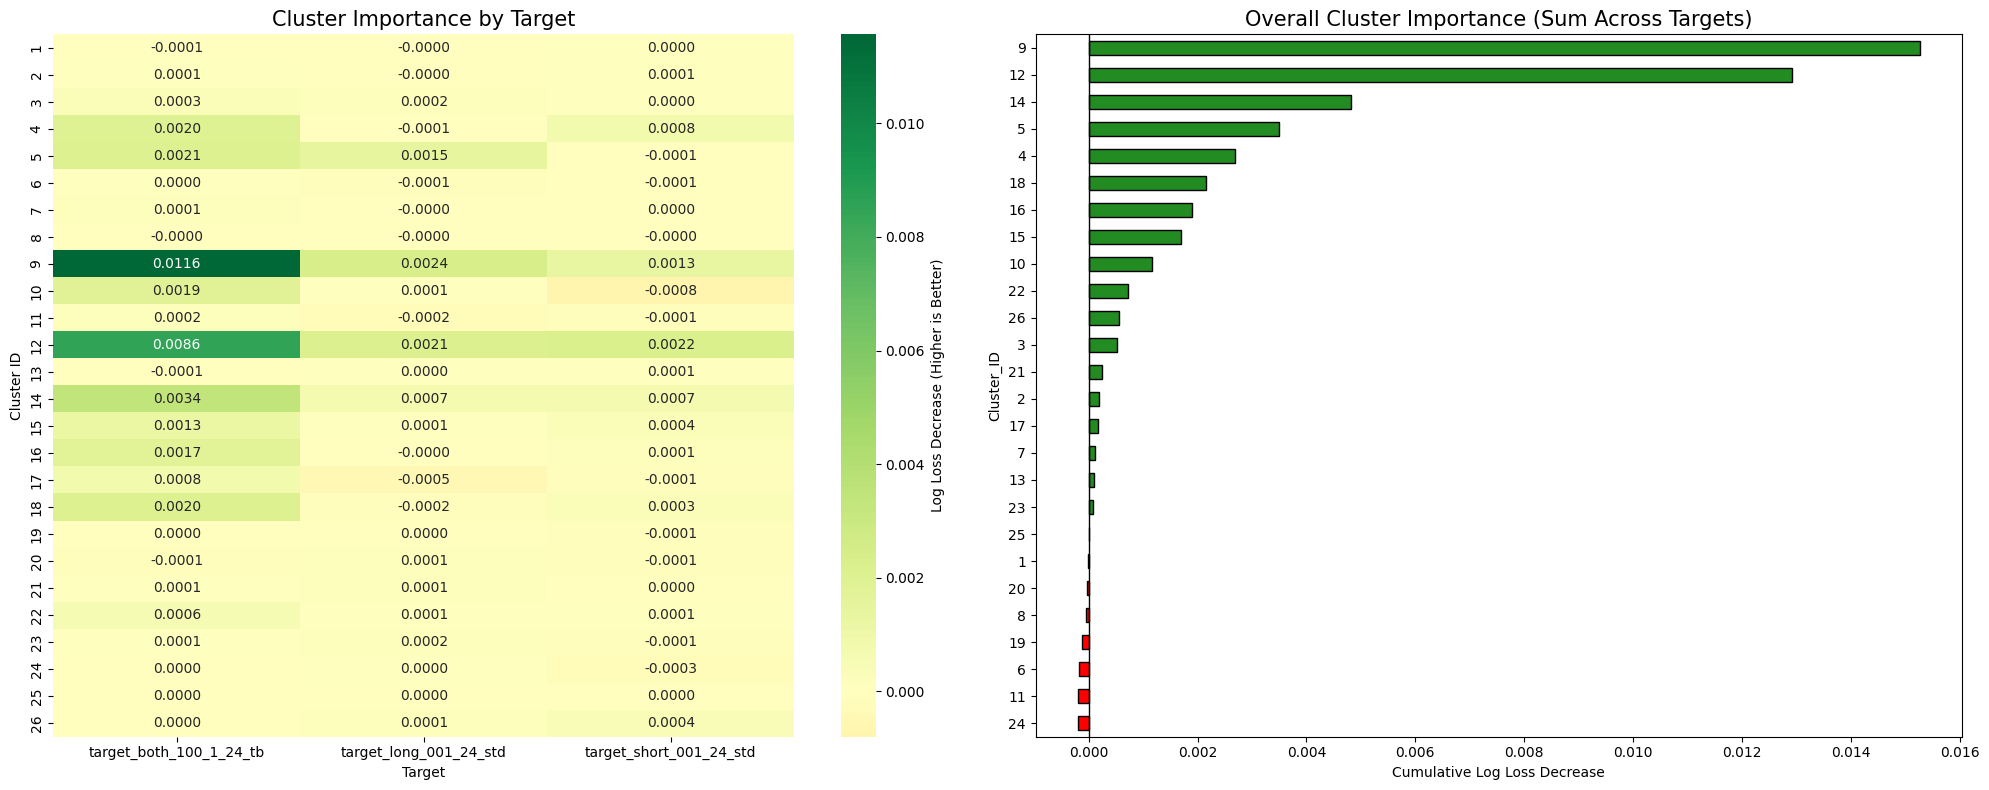


--- DECISION REPORT ---
🏆 MVP Cluster: Cluster 9 (Highest Total Signal)
⚠️  Harmful Clusters (Negative Score - REMOVE THESE): [24, 11, 6, 19, 8, 20, 1]
💤 Weak/Noise Clusters (Near Zero Impact): [25, 23, 13]


In [147]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import fcluster

# ==========================================
# FINAL CLUSTER ASSIGNMENT (Threshold = 0.3)
# ==========================================

# 1. Re-run Clustering with T=0.3
threshold = 0.1
cluster_labels = fcluster(linkage_matrix, t=threshold, criterion='distance')

# 2. Create the Final Map
feat_cluster_map = pd.DataFrame({
    'Feature': X.columns,
    'Cluster_ID': cluster_labels
})

# 3. Save/Print for Reference
print(f"--- FINAL CLUSTER CONFIGURATION (T={threshold}) ---")
print(f"Total Clusters: {feat_cluster_map['Cluster_ID'].nunique()}")

# Sort by cluster for easy reading
feat_cluster_map = feat_cluster_map.sort_values('Cluster_ID')

# Create a dictionary for quick lookups later {Feature: Cluster_ID}
feature_to_cluster = dict(zip(feat_cluster_map['Feature'], feat_cluster_map['Cluster_ID']))

# Show the breakdown
for cid in sorted(feat_cluster_map['Cluster_ID'].unique()):
    feats = feat_cluster_map[feat_cluster_map['Cluster_ID'] == cid]['Feature'].tolist()
    print(f"\nCluster {cid} ({len(feats)} features):")
    print(feats)

# ==============================================================================
# STEP 1: ROBUST ALIGNMENT & CLEANUP
# ==============================================================================
print("--- ALIGNING FEATURES AND TARGETS ---")

# 1. Merge Features (df_final) and Targets on Metadata keys
# This ensures we only keep rows where we have BOTH features AND labels.
# (We assume 'targets' dataframe has the same meta columns: SYMBOL, EXCHANGE, BAR_TIMESTAMP)
common_keys = ['BAR_TIMESTAMP', 'SYMBOL', 'EXCHANGE']

# Check if keys exist in both (handling potential index mismatch)
# If timestamps are in index, we reset them to columns for the merge
if 'BAR_TIMESTAMP' not in df_final.columns and df_final.index.name == 'BAR_TIMESTAMP':
    df_final = df_final.reset_index()
if 'BAR_TIMESTAMP' not in targets.columns and targets.index.name == 'BAR_TIMESTAMP':
    targets = targets.reset_index()

# Perform Inner Join
df_aligned = pd.merge(
    df_final, 
    targets, 
    on=common_keys, 
    how='inner'
)

# 2. Separate X (Features) and Y (Targets)
# Identify Target Columns (assuming they are the ones from the 'targets' df)
target_cols = [c for c in targets.columns if c not in common_keys]
feature_cols = [c for c in df_final.columns if c not in common_keys and c not in target_cols]

X_full = df_aligned[feature_cols].copy()
y_full = df_aligned[target_cols].copy()
# 3. DROP NON-NUMERIC COLUMNS from X
# Random Forest cannot handle 'SYMBOL' or 'EXCHANGE' strings.
# We select only numeric types (float/int).
X_numeric = X_full.select_dtypes(include=[np.number])

# Sanity Check
print(f"Aligned Rows: {len(X_numeric)}")
print(f"Feature Count: {X_numeric.shape[1]} (Numeric Only)")
print(f"Targets: {y_full.columns.tolist()}")

# 4. Update Cluster Map (Safety Step)
# Ensure our 'feature_to_cluster' map doesn't contain columns we just dropped (strings)
feature_to_cluster_clean = {k: v for k, v in feature_to_cluster.items() if k in X_numeric.columns}

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import TimeSeriesSplit

# ==============================================================================
# ENGINE: ROBUST CLUSTERED MDA (WALK-FORWARD)
# ==============================================================================
def get_robust_clustered_mda(X, y, feature_to_cluster, n_splits=3, purge_size=24):
    """
    Args:
        purge_size: 24 (Matches your Triple Barrier Expiry)
    """
    # 1. Setup Model (Light RF)
    model_params = {'n_estimators': 150, 'max_depth': 5, 'n_jobs': -1, 'random_state': 42}
    
    # 2. Walk-Forward Splitter
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_scores = []
    
    print(f"Starting {n_splits}-Fold Walk-Forward MDA (Purge={purge_size})...")
    
    for fold_idx, (train_indices, val_indices) in enumerate(tscv.split(X)):
        
        # --- PURGING ---
        # Skip the first 'purge_size' rows of validation to prevent overlap leakage
        if len(val_indices) <= purge_size:
            continue
        val_indices = val_indices[purge_size:]
        
        # Split
        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]
        
        # Fit
        clf = RandomForestClassifier(**model_params)
        clf.fit(X_train, y_train)
        
        # Base Score (Log Loss)
        base_probs = clf.predict_proba(X_val)
        base_score = log_loss(y_val, base_probs, labels=clf.classes_)
        
        # --- CLUSTER PERMUTATION ---
        fold_importances = {}
        unique_clusters = sorted(list(set(feature_to_cluster.values())))
        
        for cid in unique_clusters:
            # Get features for this cluster that exist in X
            cluster_feats = [f for f, c in feature_to_cluster.items() if c == cid and f in X.columns]
            if not cluster_feats: continue
            
            # Shuffle
            X_val_shuffled = X_val.copy()
            shuffled_vals = X_val[cluster_feats].values.copy()
            np.random.shuffle(shuffled_vals)
            X_val_shuffled[cluster_feats] = shuffled_vals
            
            # Score Drop
            shuffled_probs = clf.predict_proba(X_val_shuffled)
            shuffled_score = log_loss(y_val, shuffled_probs, labels=clf.classes_)
            
            fold_importances[cid] = shuffled_score - base_score
            
        fold_scores.append(fold_importances)
        print(f"  Fold {fold_idx+1} Base Loss: {base_score:.4f}")

    # Aggregate
    return pd.DataFrame(fold_scores).mean().to_dict()

# ==============================================================================
# EXECUTION LOOP
# ==============================================================================
mda_results = {}

for target_col in y_full.columns:
    print(f"\n--- Processing Target: {target_col} ---")
    
    # Prepare Y (Drop NaNs)
    y_series = y_full[target_col]
    valid_mask = ~y_series.isna()
    
    # Filter X and Y to match valid targets
    X_clean = X_numeric[valid_mask]
    y_clean = y_series[valid_mask]
    
    # Run MDA
    # Note: purge_size=24 matches your expiry parameters
    scores = get_robust_clustered_mda(
        X_clean, 
        y_clean, 
        feature_to_cluster_clean, 
        n_splits=3, 
        purge_size=24
    )
    
    mda_results[target_col] = scores
# ==============================================================================
# FINAL REPORT
# ==============================================================================
df_mda = pd.DataFrame(mda_results)
df_mda.index.name = "Cluster_ID"
df_mda = df_mda.sort_index()

print("\n--- FINAL CLUSTER IMPORTANCE (Log Loss Decrease) ---")
print(df_mda)

# Check for "Dead" Clusters (Negative or Zero score across all targets)
df_mda['Total_Importance'] = df_mda.sum(axis=1)
dead_clusters = df_mda[df_mda['Total_Importance'] <= 0].index.tolist()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==============================================================================
# VISUALIZE MDA RESULTS
# ==============================================================================

# 1. Setup the figure layout (2 plots: Heatmap & Bar Chart)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- PLOT A: HEATMAP (Target Specificity) ---
# This shows exactly which cluster drives which target signal.
sns.heatmap(
    df_mda.drop(columns=['Total_Importance'], errors='ignore'), # Exclude total if it exists
    annot=True,
    fmt=".4f",
    cmap="RdYlGn",   # Red = Bad (Negative), Green = Good (Positive)
    center=0,        # Center the color scale at 0 to highlight negative scores
    ax=axes[0],
    cbar_kws={'label': 'Log Loss Decrease (Higher is Better)'}
)
axes[0].set_title('Cluster Importance by Target', fontsize=15)
axes[0].set_ylabel('Cluster ID')
axes[0].set_xlabel('Target')

# --- PLOT B: RANKED BAR CHART (Overall Power) ---
# Calculate Total Importance across all targets to find the "MVPs"
total_importance = df_mda.drop(columns=['Total_Importance'], errors='ignore').sum(axis=1).sort_values(ascending=True)

# Color bars based on Positive (Green) or Negative (Red) impact
colors = ['red' if x < 0 else 'forestgreen' for x in total_importance.values]

total_importance.plot(kind='barh', ax=axes[1], color=colors, edgecolor='black')
axes[1].axvline(0, color='black', linewidth=1) # Zero line
axes[1].set_title('Overall Cluster Importance (Sum Across Targets)', fontsize=15)
axes[1].set_xlabel('Cumulative Log Loss Decrease')

plt.tight_layout()
plt.show()

# ==============================================================================
# TEXT SUMMARY
# ==============================================================================
print("\n--- DECISION REPORT ---")
# 1. Best Cluster
best_cluster = total_importance.idxmax()
print(f"🏆 MVP Cluster: Cluster {best_cluster} (Highest Total Signal)")

# 2. Worst Clusters (Negative Impact)
negative_clusters = total_importance[total_importance < 0].index.tolist()
if negative_clusters:
    print(f"⚠️  Harmful Clusters (Negative Score - REMOVE THESE): {negative_clusters}")
else:
    print("✅ No clusters were explicitly harmful (all > 0).")

# 3. Useless Clusters (Near Zero)
# Clusters that add less than 0.0001 total log loss improvement are basically noise.
useless_clusters = total_importance[(total_importance >= 0) & (total_importance < 1e-4)].index.tolist()
if useless_clusters:
    print(f"💤 Weak/Noise Clusters (Near Zero Impact): {useless_clusters}")



In [148]:
# ids =   [9,12,14,]

out = (
    cluster_df
    .merge(
        df_mda,
        left_on='Cluster_ID',
        right_index=True,
        how='inner'
    )
    .sort_values('Total_Importance', ascending=False)
)


In [149]:
out

,Feature,Cluster_ID,target_both_100_1_24_tb,target_long_001_24_std,target_short_001_24_std,Total_Importance
47,LIQUIDATION_COUNT_IMBALANCE_C,9,0.011566,0.002412,0.001293,0.015271
46,LIQUIDATION_VOLUME_IMBALANCE_C,9,0.011566,0.002412,0.001293,0.015271
9,OPEN_INTEREST_LAST_B,12,0.008550,0.002150,0.002221,0.012921
41,TICK_SPAN_B,14,0.003428,0.000688,0.000707,0.004823
38,LIQ_DURATION_B,5,0.002102,0.001457,-0.000054,0.003505
25,TOTAL_LIQUIDATION_COUNT_B,5,0.002102,0.001457,-0.000054,0.003505
22,TOTAL_LIQUIDATION_VOLUME_B,5,0.002102,0.001457,-0.000054,0.003505
33,AVG_LIQUIDATION_SIZE_B,5,0.002102,0.001457,-0.000054,0.003505
28,TOTAL_LIQUIDATION_NOTIONAL_B,5,0.002102,0.001457,-0.000054,0.003505
35,MAX_SINGLE_LIQUIDATION_NOTIONAL_B,5,0.002102,0.001457,-0.000054,0.003505


In [158]:
print(out)

                              Feature  Cluster_ID  target_both_100_1_24_tb  \
47      LIQUIDATION_COUNT_IMBALANCE_C           9                 0.011566   
46     LIQUIDATION_VOLUME_IMBALANCE_C           9                 0.011566   
9                OPEN_INTEREST_LAST_B          12                 0.008550   
41                        TICK_SPAN_B          14                 0.003428   
38                     LIQ_DURATION_B           5                 0.002102   
25          TOTAL_LIQUIDATION_COUNT_B           5                 0.002102   
22         TOTAL_LIQUIDATION_VOLUME_B           5                 0.002102   
33             AVG_LIQUIDATION_SIZE_B           5                 0.002102   
28       TOTAL_LIQUIDATION_NOTIONAL_B           5                 0.002102   
35  MAX_SINGLE_LIQUIDATION_NOTIONAL_B           5                 0.002102   
39                      LIQ_LATENCY_B           5                 0.002102   
34      MAX_SINGLE_LIQUIDATION_SIZE_B           5               

In [160]:
out.shape

(52, 6)

--- FINAL CLUSTER CONFIGURATION (T=0.5) ---
Total Clusters: 14

Cluster 1 (3 features):
['MAX_TRADE_SIZE_B', 'AVG_TRADE_SIZE_B', 'TRADE_SIZE_STDDEV_B']

Cluster 2 (11 features):
['SELL_VOLUME_B', 'VOLUME_B', 'BUY_VOLUME_B', 'SELL_NOTIONAL_B', 'NOTIONAL_VOLUME_B', 'TOTAL_TRADES_COUNT_B', 'TICK_COUNT_B', 'SELL_TRADES_COUNT_B', 'BUY_TRADES_COUNT_B', 'PRICE_STDDEV_B', 'BUY_NOTIONAL_B']

Cluster 3 (1 features):
['TRADE_SPAN_B']

Cluster 4 (4 features):
['BUY_LIQUIDATION_COUNT_B', 'AVG_BUY_LIQUIDATION_SIZE_B', 'BUY_LIQUIDATION_VOLUME_B', 'BUY_LIQUIDATION_NOTIONAL_B']

Cluster 5 (8 features):
['TOTAL_LIQUIDATION_NOTIONAL_B', 'AVG_LIQUIDATION_SIZE_B', 'TOTAL_LIQUIDATION_VOLUME_B', 'TOTAL_LIQUIDATION_COUNT_B', 'LIQ_DURATION_B', 'MAX_SINGLE_LIQUIDATION_SIZE_B', 'LIQ_LATENCY_B', 'MAX_SINGLE_LIQUIDATION_NOTIONAL_B']

Cluster 6 (9 features):
['LAST_PRICE_LAST_A', 'HIGH_PRICE_A', 'AVG_PRICE_A', 'MARK_PRICE_LAST_A', 'INDEX_PRICE_LAST_A', 'CLOSE_PRICE_A', 'LOW_PRICE_A', 'OPEN_PRICE_A', 'VWAP_A']

Clus

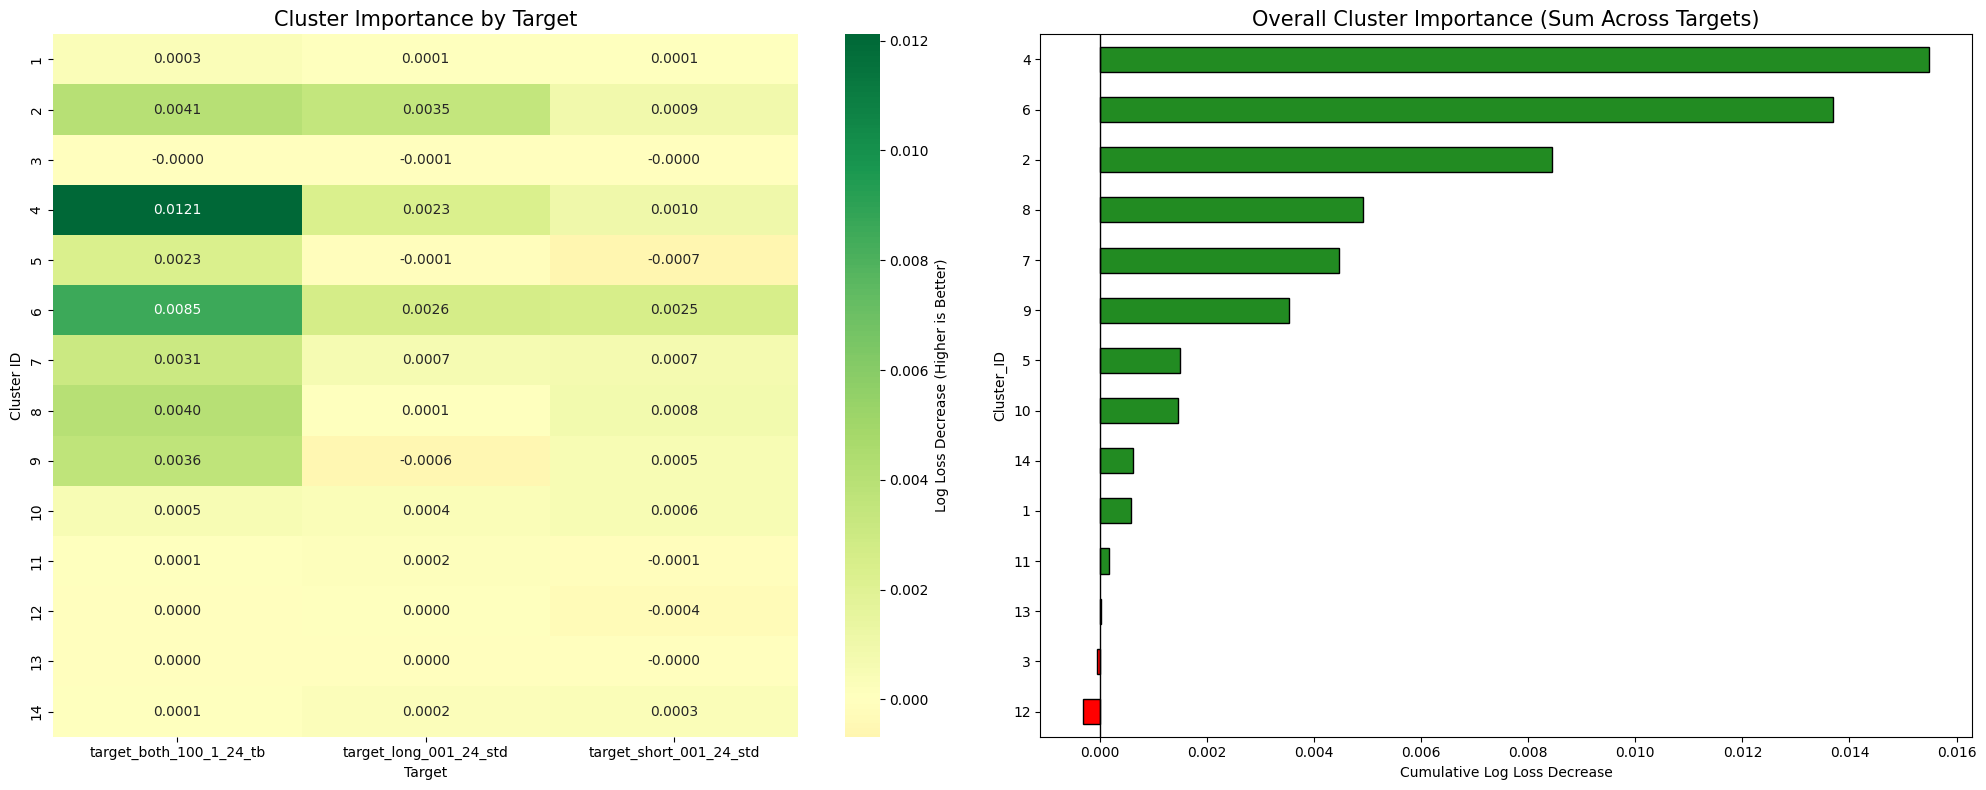


--- DECISION REPORT ---
🏆 MVP Cluster: Cluster 4 (Highest Total Signal)
⚠️  Harmful Clusters (Negative Score - REMOVE THESE): [12, 3]
💤 Weak/Noise Clusters (Near Zero Impact): [13]


In [150]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import fcluster

# ==========================================
# FINAL CLUSTER ASSIGNMENT (Threshold = 0.3)
# ==========================================

# 1. Re-run Clustering with T=0.3
threshold = 0.5
cluster_labels = fcluster(linkage_matrix, t=threshold, criterion='distance')

# 2. Create the Final Map
feat_cluster_map = pd.DataFrame({
    'Feature': X.columns,
    'Cluster_ID': cluster_labels
})

# 3. Save/Print for Reference
print(f"--- FINAL CLUSTER CONFIGURATION (T={threshold}) ---")
print(f"Total Clusters: {feat_cluster_map['Cluster_ID'].nunique()}")

# Sort by cluster for easy reading
feat_cluster_map = feat_cluster_map.sort_values('Cluster_ID')

# Create a dictionary for quick lookups later {Feature: Cluster_ID}
feature_to_cluster = dict(zip(feat_cluster_map['Feature'], feat_cluster_map['Cluster_ID']))

# Show the breakdown
for cid in sorted(feat_cluster_map['Cluster_ID'].unique()):
    feats = feat_cluster_map[feat_cluster_map['Cluster_ID'] == cid]['Feature'].tolist()
    print(f"\nCluster {cid} ({len(feats)} features):")
    print(feats)

# ==============================================================================
# STEP 1: ROBUST ALIGNMENT & CLEANUP
# ==============================================================================
print("--- ALIGNING FEATURES AND TARGETS ---")

# 1. Merge Features (df_final) and Targets on Metadata keys
# This ensures we only keep rows where we have BOTH features AND labels.
# (We assume 'targets' dataframe has the same meta columns: SYMBOL, EXCHANGE, BAR_TIMESTAMP)
common_keys = ['BAR_TIMESTAMP', 'SYMBOL', 'EXCHANGE']

# Check if keys exist in both (handling potential index mismatch)
# If timestamps are in index, we reset them to columns for the merge
if 'BAR_TIMESTAMP' not in df_final.columns and df_final.index.name == 'BAR_TIMESTAMP':
    df_final = df_final.reset_index()
if 'BAR_TIMESTAMP' not in targets.columns and targets.index.name == 'BAR_TIMESTAMP':
    targets = targets.reset_index()

# Perform Inner Join
df_aligned = pd.merge(
    df_final, 
    targets, 
    on=common_keys, 
    how='inner'
)

# 2. Separate X (Features) and Y (Targets)
# Identify Target Columns (assuming they are the ones from the 'targets' df)
target_cols = [c for c in targets.columns if c not in common_keys]
feature_cols = [c for c in df_final.columns if c not in common_keys and c not in target_cols]

X_full = df_aligned[feature_cols].copy()
y_full = df_aligned[target_cols].copy()
# 3. DROP NON-NUMERIC COLUMNS from X
# Random Forest cannot handle 'SYMBOL' or 'EXCHANGE' strings.
# We select only numeric types (float/int).
X_numeric = X_full.select_dtypes(include=[np.number])

# Sanity Check
print(f"Aligned Rows: {len(X_numeric)}")
print(f"Feature Count: {X_numeric.shape[1]} (Numeric Only)")
print(f"Targets: {y_full.columns.tolist()}")

# 4. Update Cluster Map (Safety Step)
# Ensure our 'feature_to_cluster' map doesn't contain columns we just dropped (strings)
feature_to_cluster_clean = {k: v for k, v in feature_to_cluster.items() if k in X_numeric.columns}

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import TimeSeriesSplit

# ==============================================================================
# ENGINE: ROBUST CLUSTERED MDA (WALK-FORWARD)
# ==============================================================================
def get_robust_clustered_mda(X, y, feature_to_cluster, n_splits=3, purge_size=24):
    """
    Args:
        purge_size: 24 (Matches your Triple Barrier Expiry)
    """
    # 1. Setup Model (Light RF)
    model_params = {'n_estimators': 150, 'max_depth': 5, 'n_jobs': -1, 'random_state': 42}
    
    # 2. Walk-Forward Splitter
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_scores = []
    
    print(f"Starting {n_splits}-Fold Walk-Forward MDA (Purge={purge_size})...")
    
    for fold_idx, (train_indices, val_indices) in enumerate(tscv.split(X)):
        
        # --- PURGING ---
        # Skip the first 'purge_size' rows of validation to prevent overlap leakage
        if len(val_indices) <= purge_size:
            continue
        val_indices = val_indices[purge_size:]
        
        # Split
        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]
        
        # Fit
        clf = RandomForestClassifier(**model_params)
        clf.fit(X_train, y_train)
        
        # Base Score (Log Loss)
        base_probs = clf.predict_proba(X_val)
        base_score = log_loss(y_val, base_probs, labels=clf.classes_)
        
        # --- CLUSTER PERMUTATION ---
        fold_importances = {}
        unique_clusters = sorted(list(set(feature_to_cluster.values())))
        
        for cid in unique_clusters:
            # Get features for this cluster that exist in X
            cluster_feats = [f for f, c in feature_to_cluster.items() if c == cid and f in X.columns]
            if not cluster_feats: continue
            
            # Shuffle
            X_val_shuffled = X_val.copy()
            shuffled_vals = X_val[cluster_feats].values.copy()
            np.random.shuffle(shuffled_vals)
            X_val_shuffled[cluster_feats] = shuffled_vals
            
            # Score Drop
            shuffled_probs = clf.predict_proba(X_val_shuffled)
            shuffled_score = log_loss(y_val, shuffled_probs, labels=clf.classes_)
            
            fold_importances[cid] = shuffled_score - base_score
            
        fold_scores.append(fold_importances)
        print(f"  Fold {fold_idx+1} Base Loss: {base_score:.4f}")

    # Aggregate
    return pd.DataFrame(fold_scores).mean().to_dict()

# ==============================================================================
# EXECUTION LOOP
# ==============================================================================
mda_results = {}

for target_col in y_full.columns:
    print(f"\n--- Processing Target: {target_col} ---")
    
    # Prepare Y (Drop NaNs)
    y_series = y_full[target_col]
    valid_mask = ~y_series.isna()
    
    # Filter X and Y to match valid targets
    X_clean = X_numeric[valid_mask]
    y_clean = y_series[valid_mask]
    
    # Run MDA
    # Note: purge_size=24 matches your expiry parameters
    scores = get_robust_clustered_mda(
        X_clean, 
        y_clean, 
        feature_to_cluster_clean, 
        n_splits=3, 
        purge_size=24
    )
    
    mda_results[target_col] = scores
# ==============================================================================
# FINAL REPORT
# ==============================================================================
df_mda = pd.DataFrame(mda_results)
df_mda.index.name = "Cluster_ID"
df_mda = df_mda.sort_index()

print("\n--- FINAL CLUSTER IMPORTANCE (Log Loss Decrease) ---")
print(df_mda)

# Check for "Dead" Clusters (Negative or Zero score across all targets)
df_mda['Total_Importance'] = df_mda.sum(axis=1)
dead_clusters = df_mda[df_mda['Total_Importance'] <= 0].index.tolist()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==============================================================================
# VISUALIZE MDA RESULTS
# ==============================================================================

# 1. Setup the figure layout (2 plots: Heatmap & Bar Chart)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- PLOT A: HEATMAP (Target Specificity) ---
# This shows exactly which cluster drives which target signal.
sns.heatmap(
    df_mda.drop(columns=['Total_Importance'], errors='ignore'), # Exclude total if it exists
    annot=True,
    fmt=".4f",
    cmap="RdYlGn",   # Red = Bad (Negative), Green = Good (Positive)
    center=0,        # Center the color scale at 0 to highlight negative scores
    ax=axes[0],
    cbar_kws={'label': 'Log Loss Decrease (Higher is Better)'}
)
axes[0].set_title('Cluster Importance by Target', fontsize=15)
axes[0].set_ylabel('Cluster ID')
axes[0].set_xlabel('Target')

# --- PLOT B: RANKED BAR CHART (Overall Power) ---
# Calculate Total Importance across all targets to find the "MVPs"
total_importance = df_mda.drop(columns=['Total_Importance'], errors='ignore').sum(axis=1).sort_values(ascending=True)

# Color bars based on Positive (Green) or Negative (Red) impact
colors = ['red' if x < 0 else 'forestgreen' for x in total_importance.values]

total_importance.plot(kind='barh', ax=axes[1], color=colors, edgecolor='black')
axes[1].axvline(0, color='black', linewidth=1) # Zero line
axes[1].set_title('Overall Cluster Importance (Sum Across Targets)', fontsize=15)
axes[1].set_xlabel('Cumulative Log Loss Decrease')

plt.tight_layout()
plt.show()

# ==============================================================================
# TEXT SUMMARY
# ==============================================================================
print("\n--- DECISION REPORT ---")
# 1. Best Cluster
best_cluster = total_importance.idxmax()
print(f"🏆 MVP Cluster: Cluster {best_cluster} (Highest Total Signal)")

# 2. Worst Clusters (Negative Impact)
negative_clusters = total_importance[total_importance < 0].index.tolist()
if negative_clusters:
    print(f"⚠️  Harmful Clusters (Negative Score - REMOVE THESE): {negative_clusters}")
else:
    print("✅ No clusters were explicitly harmful (all > 0).")

# 3. Useless Clusters (Near Zero)
# Clusters that add less than 0.0001 total log loss improvement are basically noise.
useless_clusters = total_importance[(total_importance >= 0) & (total_importance < 1e-4)].index.tolist()
if useless_clusters:
    print(f"💤 Weak/Noise Clusters (Near Zero Impact): {useless_clusters}")



In [151]:
# ids =   [9,12,14,]

out2 = (
    cluster_df
    .merge(
        df_mda,
        left_on='Cluster_ID',
        right_index=True,
        how='inner'
    )
    .sort_values('Total_Importance', ascending=False)
)


In [152]:
out2

,Feature,Cluster_ID,target_both_100_1_24_tb,target_long_001_24_std,target_short_001_24_std,Total_Importance
20,BUY_LIQUIDATION_VOLUME_B,4,1.211569e-02,0.002339,1.037106e-03,0.015492
31,AVG_BUY_LIQUIDATION_SIZE_B,4,1.211569e-02,0.002339,1.037106e-03,0.015492
23,BUY_LIQUIDATION_COUNT_B,4,1.211569e-02,0.002339,1.037106e-03,0.015492
26,BUY_LIQUIDATION_NOTIONAL_B,4,1.211569e-02,0.002339,1.037106e-03,0.015492
1,HIGH_PRICE_A,6,8.531146e-03,0.002631,2.524642e-03,0.013687
5,AVG_PRICE_A,6,8.531146e-03,0.002631,2.524642e-03,0.013687
6,MARK_PRICE_LAST_A,6,8.531146e-03,0.002631,2.524642e-03,0.013687
7,INDEX_PRICE_LAST_A,6,8.531146e-03,0.002631,2.524642e-03,0.013687
3,CLOSE_PRICE_A,6,8.531146e-03,0.002631,2.524642e-03,0.013687
2,LOW_PRICE_A,6,8.531146e-03,0.002631,2.524642e-03,0.013687


In [157]:
print(out2)

                              Feature  Cluster_ID  target_both_100_1_24_tb  \
20           BUY_LIQUIDATION_VOLUME_B           4             1.211569e-02   
31         AVG_BUY_LIQUIDATION_SIZE_B           4             1.211569e-02   
23            BUY_LIQUIDATION_COUNT_B           4             1.211569e-02   
26         BUY_LIQUIDATION_NOTIONAL_B           4             1.211569e-02   
1                        HIGH_PRICE_A           6             8.531146e-03   
5                         AVG_PRICE_A           6             8.531146e-03   
6                   MARK_PRICE_LAST_A           6             8.531146e-03   
7                  INDEX_PRICE_LAST_A           6             8.531146e-03   
3                       CLOSE_PRICE_A           6             8.531146e-03   
2                         LOW_PRICE_A           6             8.531146e-03   
4                              VWAP_A           6             8.531146e-03   
8                   LAST_PRICE_LAST_A           6             8.

In [161]:
out2.shape

(51, 6)

In [ ]:
r1 = (
    out[['Feature', 'Total_Importance']]
    .assign(rank_1=lambda x: x['Total_Importance'].rank(
        ascending=False, method='min'
    ))
)

r2 = (
    out2[['Feature', 'Total_Importance']]
    .assign(rank_2=lambda x: x['Total_Importance'].rank(
        ascending=False, method='min'
    ))
)


In [ ]:
rank_change = (
    r1.merge(r2, on='Feature', how='outer')
    .assign(
        rank_change=lambda x: x['rank_2'] - x['rank_1']
    )
    .sort_values('rank_change')
)


In [159]:
rank_change

,Feature,Total_Importance_x,rank_1,Total_Importance_y,rank_2,rank_change
2,AVG_PRICE_A,-0.000185,42.0,0.013687,5.0,-37.0
11,CLOSE_PRICE_A,-0.000185,42.0,0.013687,5.0,-37.0
31,OPEN_PRICE_A,-0.000185,42.0,0.013687,5.0,-37.0
25,MARK_PRICE_LAST_A,-0.000185,42.0,0.013687,5.0,-37.0
24,LOW_PRICE_A,-0.000185,42.0,0.013687,5.0,-37.0
19,LAST_PRICE_LAST_A,-0.000185,42.0,0.013687,5.0,-37.0
18,INDEX_PRICE_LAST_A,-0.000185,42.0,0.013687,5.0,-37.0
17,HIGH_PRICE_A,-0.000185,42.0,0.013687,5.0,-37.0
51,VWAP_A,-0.000185,42.0,0.013687,5.0,-37.0
46,TRADE_COUNT_IMBALANCE_C,-0.000048,40.0,0.004914,25.0,-15.0


In [167]:
print(rank_change)

                              Feature  Total_Importance_x  rank_1  \
2                         AVG_PRICE_A           -0.000185    42.0   
11                      CLOSE_PRICE_A           -0.000185    42.0   
31                       OPEN_PRICE_A           -0.000185    42.0   
25                  MARK_PRICE_LAST_A           -0.000185    42.0   
24                        LOW_PRICE_A           -0.000185    42.0   
19                  LAST_PRICE_LAST_A           -0.000185    42.0   
18                 INDEX_PRICE_LAST_A           -0.000185    42.0   
17                       HIGH_PRICE_A           -0.000185    42.0   
51                             VWAP_A           -0.000185    42.0   
46            TRADE_COUNT_IMBALANCE_C           -0.000048    40.0   
50                 VOLUME_IMBALANCE_C           -0.000048    40.0   
7            BUY_LIQUIDATION_VOLUME_B            0.002696    13.0   
6          BUY_LIQUIDATION_NOTIONAL_B            0.002696    13.0   
5             BUY_LIQUIDATION_COUN

In [ ]:
r1 = (
    out[['Feature', 'target_long_001_24_std']]
    .assign(rank_1=lambda x: x['target_long_001_24_std'].rank(
        ascending=False, method='min'
    ))
)

r2 = (
    out2[['Feature', 'target_long_001_24_std']]
    .assign(rank_2=lambda x: x['target_long_001_24_std'].rank(
        ascending=False, method='min'
    ))
)

rank_change_long = (
    r1.merge(r2, on='Feature', how='outer')
    .assign(
        rank_change=lambda x: x['rank_2'] - x['rank_1']
    )
    .sort_values('rank_change')
)
rank_change_long


,Feature,target_long_001_24_std_x,rank_1,target_long_001_24_std_y,rank_2,rank_change
2,AVG_PRICE_A,-0.000148,42.0,0.002631,12.0,-30.0
11,CLOSE_PRICE_A,-0.000148,42.0,0.002631,12.0,-30.0
31,OPEN_PRICE_A,-0.000148,42.0,0.002631,12.0,-30.0
25,MARK_PRICE_LAST_A,-0.000148,42.0,0.002631,12.0,-30.0
24,LOW_PRICE_A,-0.000148,42.0,0.002631,12.0,-30.0
19,LAST_PRICE_LAST_A,-0.000148,42.0,0.002631,12.0,-30.0
18,INDEX_PRICE_LAST_A,-0.000148,42.0,0.002631,12.0,-30.0
17,HIGH_PRICE_A,-0.000148,42.0,0.002631,12.0,-30.0
51,VWAP_A,-0.000148,42.0,0.002631,12.0,-30.0
15,DIST_VWAP_LIQ_C,-0.000247,51.0,0.000164,32.0,-19.0


In [165]:
print(rank_change_long)

                              Feature  target_long_001_24_std_x  rank_1  \
2                         AVG_PRICE_A                 -0.000148    42.0   
11                      CLOSE_PRICE_A                 -0.000148    42.0   
31                       OPEN_PRICE_A                 -0.000148    42.0   
25                  MARK_PRICE_LAST_A                 -0.000148    42.0   
24                        LOW_PRICE_A                 -0.000148    42.0   
19                  LAST_PRICE_LAST_A                 -0.000148    42.0   
18                 INDEX_PRICE_LAST_A                 -0.000148    42.0   
17                       HIGH_PRICE_A                 -0.000148    42.0   
51                             VWAP_A                 -0.000148    42.0   
15                    DIST_VWAP_LIQ_C                 -0.000247    51.0   
14                     DIST_MIN_LIQ_C                 -0.000247    51.0   
10                       BUY_VOLUME_B                 -0.000002    18.0   
7            BUY_LIQUIDAT

In [164]:
r1 = (
    out[['Feature', 'target_short_001_24_std']]
    .assign(rank_1=lambda x: x['target_short_001_24_std'].rank(
        ascending=False, method='min'
    ))
)

r2 = (
    out2[['Feature', 'target_short_001_24_std']]
    .assign(rank_2=lambda x: x['target_short_001_24_std'].rank(
        ascending=False, method='min'
    ))
)

rank_change_short = (
    r1.merge(r2, on='Feature', how='outer')
    .assign(
        rank_change=lambda x: x['rank_2'] - x['rank_1']
    )
    .sort_values('rank_change')
)
rank_change_short


,Feature,target_short_001_24_std_x,rank_1,target_short_001_24_std_y,rank_2,rank_change
2,AVG_PRICE_A,-0.000065,40.0,2.524642e-03,1.0,-39.0
11,CLOSE_PRICE_A,-0.000065,40.0,2.524642e-03,1.0,-39.0
31,OPEN_PRICE_A,-0.000065,40.0,2.524642e-03,1.0,-39.0
25,MARK_PRICE_LAST_A,-0.000065,40.0,2.524642e-03,1.0,-39.0
24,LOW_PRICE_A,-0.000065,40.0,2.524642e-03,1.0,-39.0
19,LAST_PRICE_LAST_A,-0.000065,40.0,2.524642e-03,1.0,-39.0
18,INDEX_PRICE_LAST_A,-0.000065,40.0,2.524642e-03,1.0,-39.0
17,HIGH_PRICE_A,-0.000065,40.0,2.524642e-03,1.0,-39.0
51,VWAP_A,-0.000065,40.0,2.524642e-03,1.0,-39.0
12,DIST_AVG_LIQ_C,-0.000794,51.0,5.552349e-04,31.0,-20.0


In [166]:
print(rank_change_short)

                              Feature  target_short_001_24_std_x  rank_1  \
2                         AVG_PRICE_A                  -0.000065    40.0   
11                      CLOSE_PRICE_A                  -0.000065    40.0   
31                       OPEN_PRICE_A                  -0.000065    40.0   
25                  MARK_PRICE_LAST_A                  -0.000065    40.0   
24                        LOW_PRICE_A                  -0.000065    40.0   
19                  LAST_PRICE_LAST_A                  -0.000065    40.0   
18                 INDEX_PRICE_LAST_A                  -0.000065    40.0   
17                       HIGH_PRICE_A                  -0.000065    40.0   
51                             VWAP_A                  -0.000065    40.0   
12                     DIST_AVG_LIQ_C                  -0.000794    51.0   
13                     DIST_MAX_LIQ_C                  -0.000794    51.0   
14                     DIST_MIN_LIQ_C                  -0.000106    49.0   
15          